# Spleen 3D segmentation with MONAI

This tutorial shows how to integrate MONAI into an existing PyTorch medical DL program.

And easily use below features:
1. Transforms for dictionary format data.
1. Load Nifti image with metadata.
1. Add channel dim to the data if no channel dimension.
1. Scale medical image intensity with expected range.
1. Crop out a batch of balanced images based on positive / negative label ratio.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Sliding window inference method.
1. Deterministic training for reproducibility.

The Spleen dataset can be downloaded from http://medicaldecathlon.com/.

![spleen](http://medicaldecathlon.com/img/spleen0.png)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb)

## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.1/264.1 KB 26.7 MB/s eta 0:00:00


In [ ]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    RandAffined,
    DivisiblePadd,
    SqueezeDimd,
    Resized,
    SpatialCropD,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet, VNet, SwinUNETR
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch, PatchIterd, GridPatchDataset
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

## Setup imports

In [ ]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


print_config()

MONAI version: 1.2.dev2302
Numpy version: 1.21.6
Pytorch version: 1.13.0+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 708e1a1cf4a1d5516eaf65b8a0bee8887cdee494
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.9.1
gdown version: 4.4.0
TorchVision version: 0.14.0+cu116
tqdm version: 4.64.1
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpwp4ipfis


## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

In [ ]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Task09_Spleen.tar: 1.50GB [00:35, 45.4MB/s]                            

2023-01-16 19:24:21,746 - INFO - Downloaded: /tmp/tmpbd6fwkg5/Task09_Spleen.tar


2023-01-16 19:24:24,941 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2023-01-16 19:24:24,942 - INFO - Writing into directory: /tmp/tmpbd6fwkg5.


## Set MSD Spleen dataset path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path1='/content/drive/My Drive/Dataset/DATA/Img/thigh'
file_path2='/content/drive/My Drive/Dataset/DATA/Label/thigh'

In [ ]:
train_images = sorted(
    glob.glob(os.path.join(file_path1, "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(file_path2, "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-6], data_dicts[-6:]

In [ ]:
print(val_files)

[{'image': '/content/drive/My Drive/Dataset/DATA/Img/thigh/MM77PS.nii.gz', 'label': '/content/drive/My Drive/Dataset/DATA/Label/thigh/MM77PS.nii.gz'}, {'image': '/content/drive/My Drive/Dataset/DATA/Img/thigh/MM78BP.nii.gz', 'label': '/content/drive/My Drive/Dataset/DATA/Label/thigh/MM78BP.nii.gz'}, {'image': '/content/drive/My Drive/Dataset/DATA/Img/thigh/MM81LS.nii.gz', 'label': '/content/drive/My Drive/Dataset/DATA/Label/thigh/MM81LS.nii.gz'}, {'image': '/content/drive/My Drive/Dataset/DATA/Img/thigh/MM85GN.nii.gz', 'label': '/content/drive/My Drive/Dataset/DATA/Label/thigh/MM85GN.nii.gz'}, {'image': '/content/drive/My Drive/Dataset/DATA/Img/thigh/MM90AE.nii.gz', 'label': '/content/drive/My Drive/Dataset/DATA/Label/thigh/MM90AE.nii.gz'}, {'image': '/content/drive/My Drive/Dataset/DATA/Img/thigh/MM93AC.nii.gz', 'label': '/content/drive/My Drive/Dataset/DATA/Label/thigh/MM93AC.nii.gz'}]


## Set deterministic training for reproducibility

In [ ]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [ ]:
import numpy as np

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=4095,
            b_min=0.0, b_max=1.0,
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        #SpatialCropD(keys=["label"], roi_start=(0,0,0), roi_end=(224,224,48)),

        # user can also add other random transforms

    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=4095,
            b_min=0.0, b_max=1.0,
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
     #SpatialCropD(keys=["label"], roi_start=(0,0,0), roi_end=(224,224,48)),


    ]
)

## Check transforms in DataLoader

image shape: torch.Size([320, 240, 48]), label shape: torch.Size([320, 240, 48])


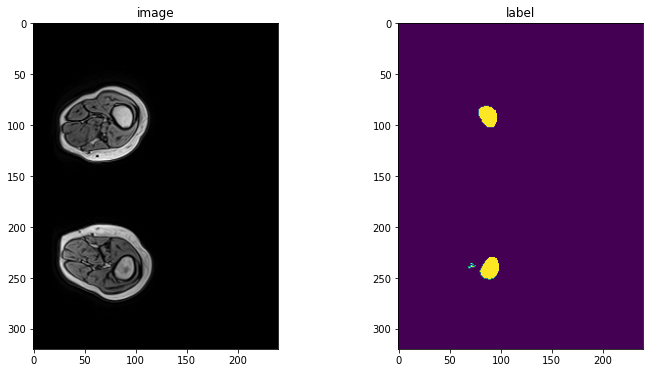

In [ ]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 20], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 20])
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [ ]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
#train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
#val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]


Loading dataset: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]


image shape: torch.Size([320, 240]), label shape: torch.Size([320, 240])


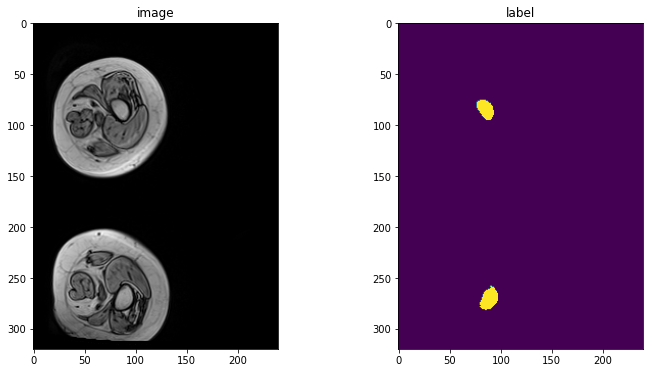

In [ ]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
patch_func = PatchIterd(
    keys=["image", "label"],
    patch_size=(None, None, 1),  # dynamic first two dimensions
    start_pos=(0, 0, 0)
)
patch_transform = Compose(
    [
        SqueezeDimd(keys=["image", "label"], dim=-1),  # squeeze the last dim
        Resized(keys=["image", "label"], spatial_size=[320, 240]),
        # to use crop/pad instead of reszie:
        # ResizeWithPadOrCropd(keys=["img", "seg"], spatial_size=[48, 48], mode="replicate"),
    ]
)
patch_train_ds = GridPatchDataset(
    data=train_ds, patch_iter=patch_func, transform=patch_transform, with_coordinates=False)
patch_val_ds = GridPatchDataset(
    data=val_ds, patch_iter=patch_func, transform=patch_transform, with_coordinates=False)
train_loader = DataLoader(
    patch_train_ds,
    batch_size=4,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
)
val_loader = DataLoader(
    patch_val_ds,
    batch_size=4,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
)
check_data = first(train_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label)
plt.show()

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


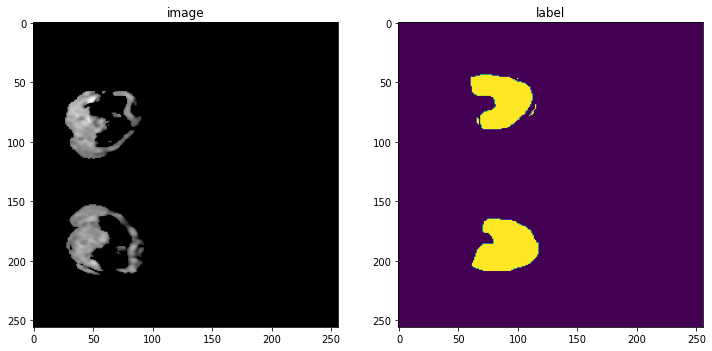

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


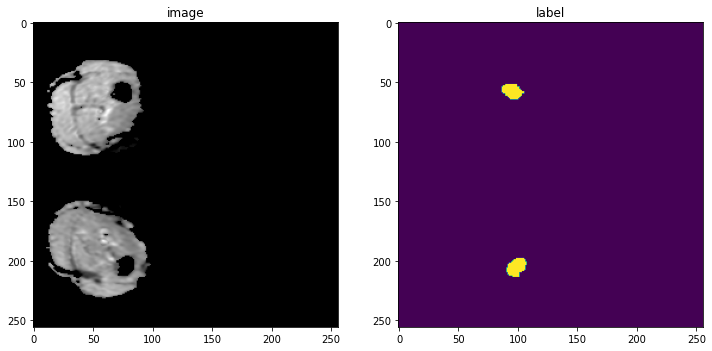

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


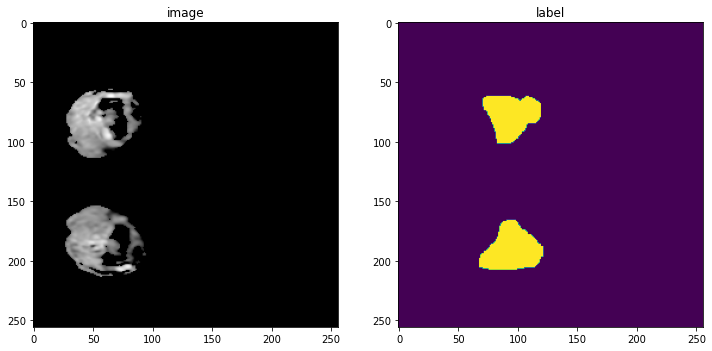

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


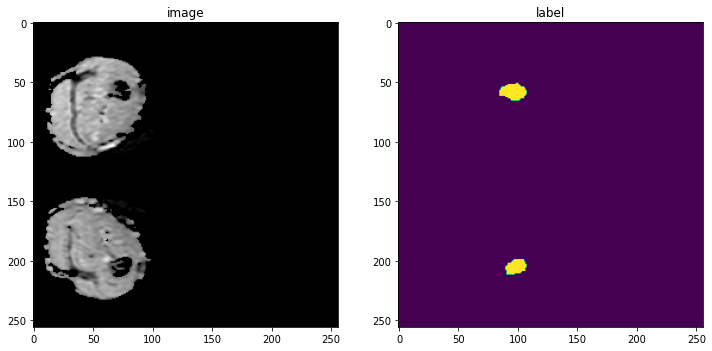

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


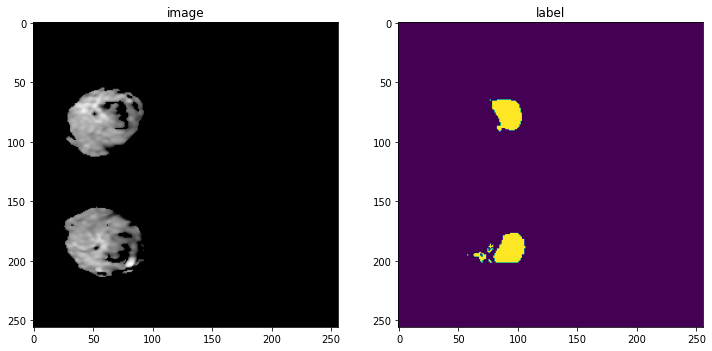

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


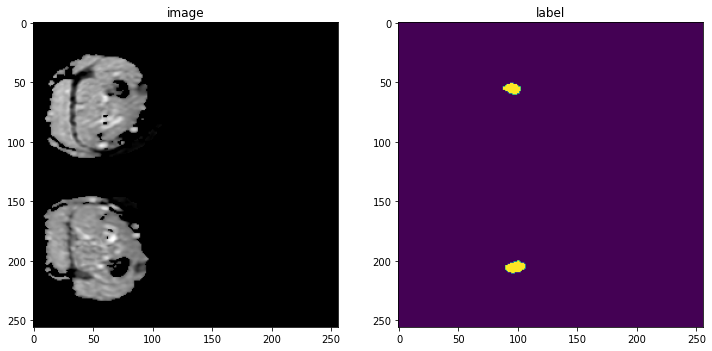

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


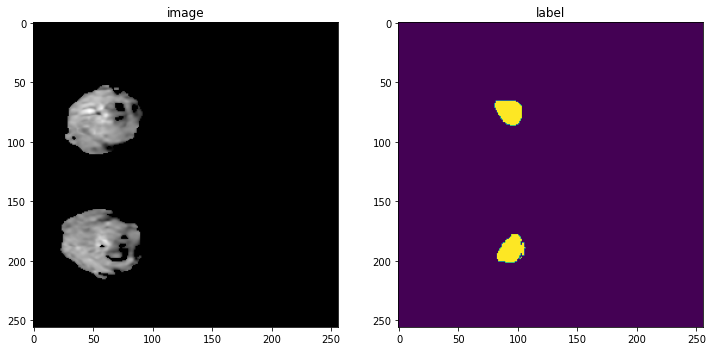

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


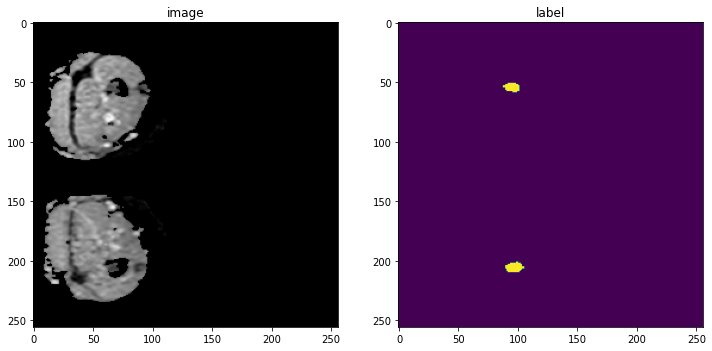

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


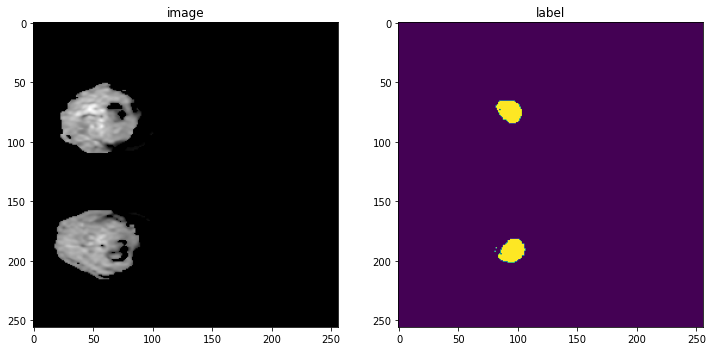

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


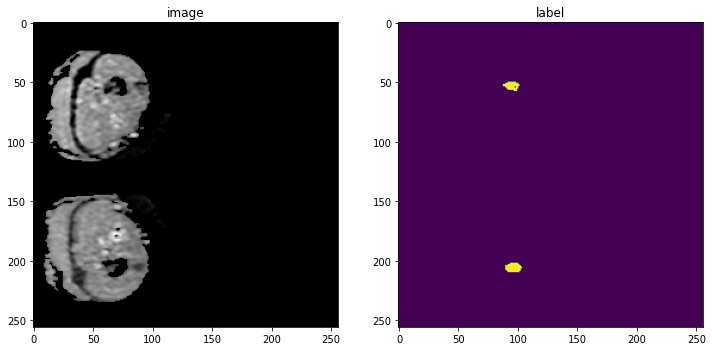

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


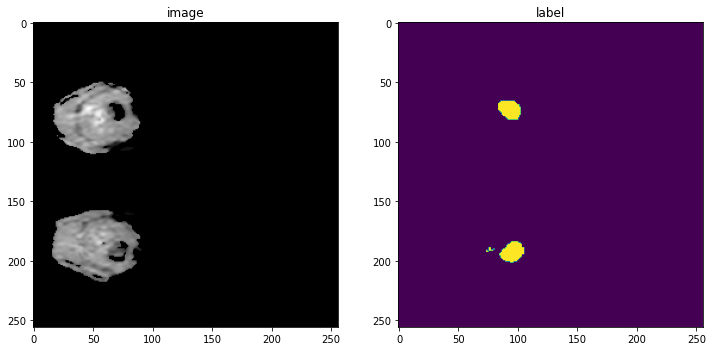

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


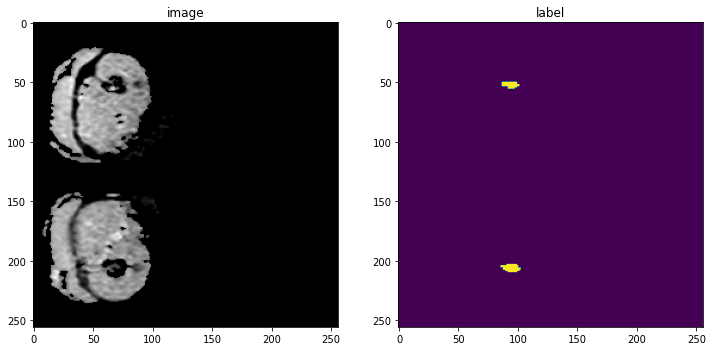

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


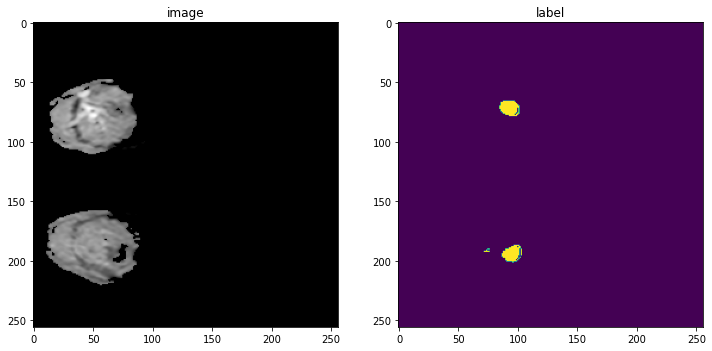

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


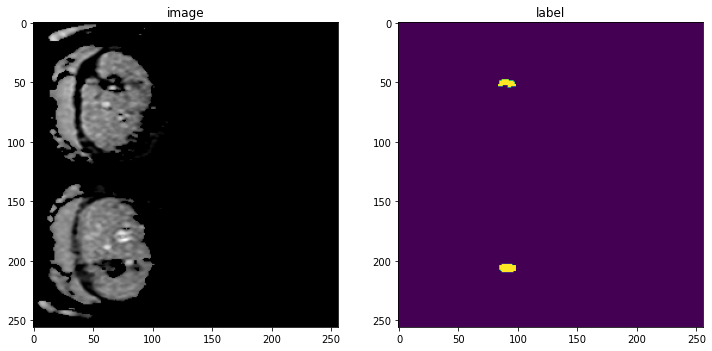

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


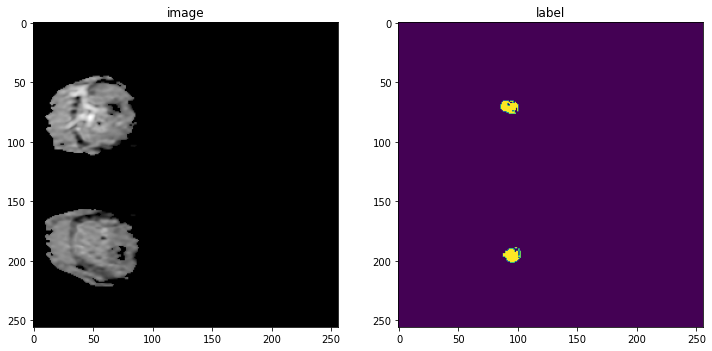

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


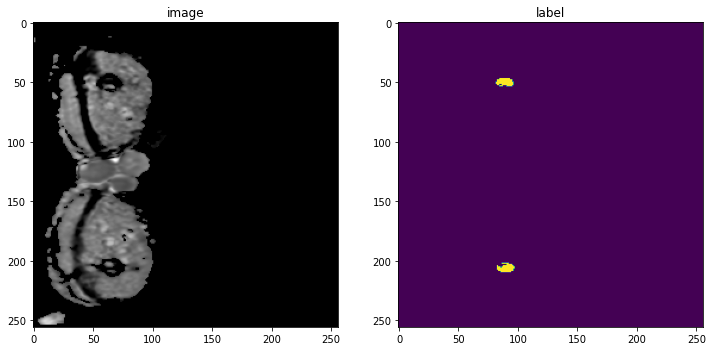

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


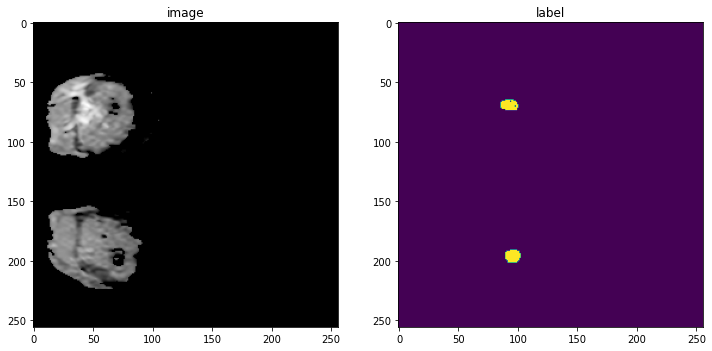

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


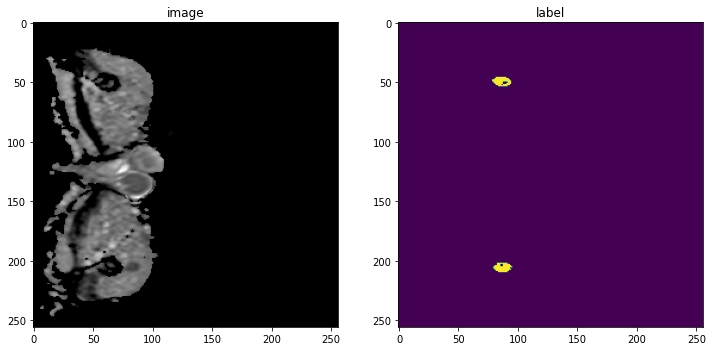

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


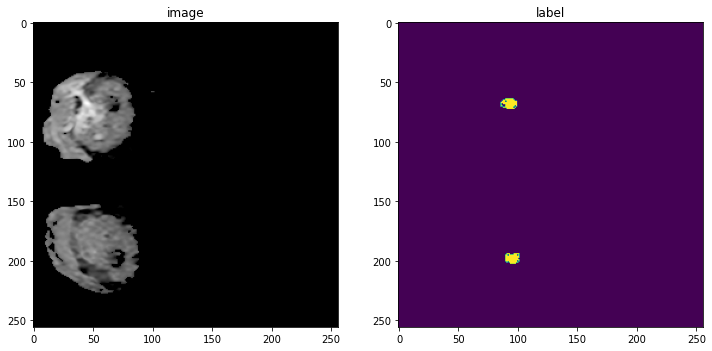

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


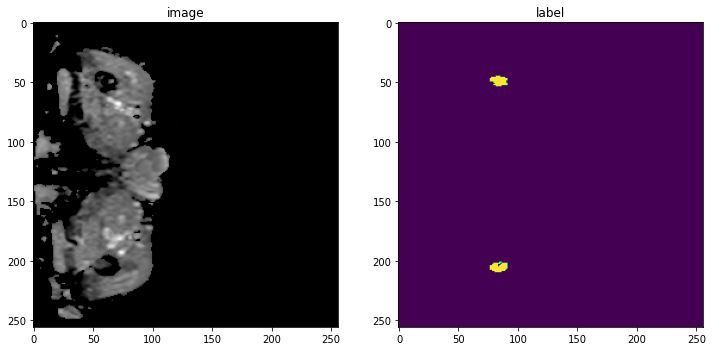

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


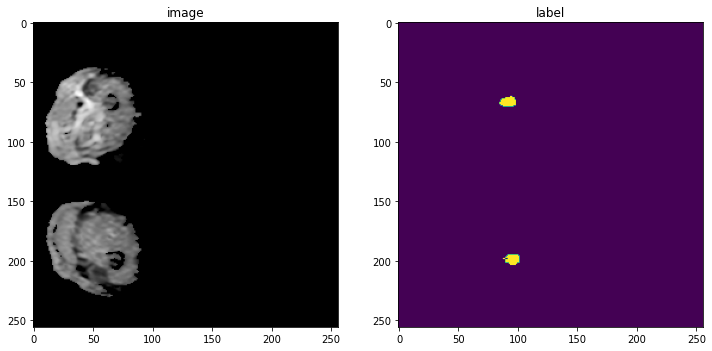

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


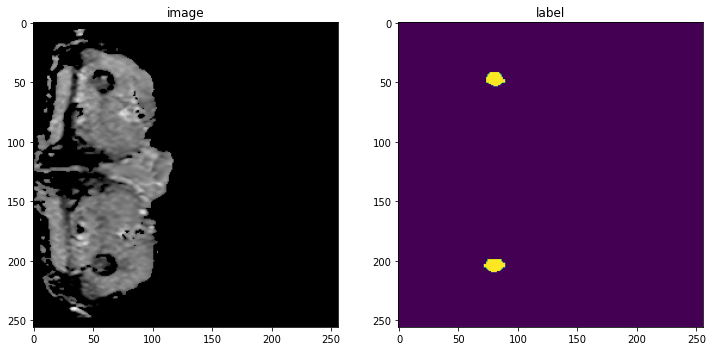

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


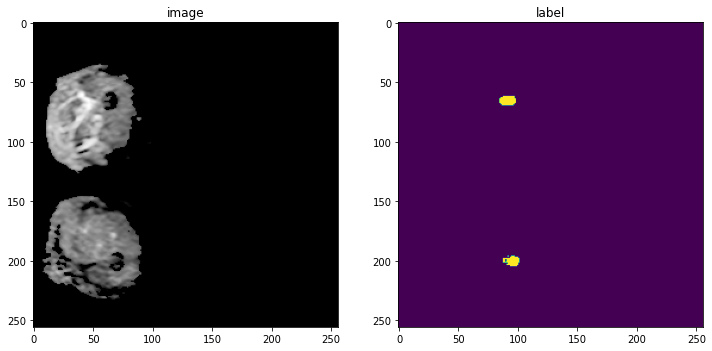

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


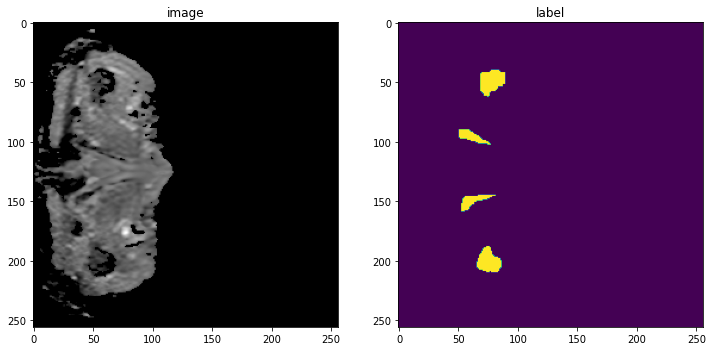

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


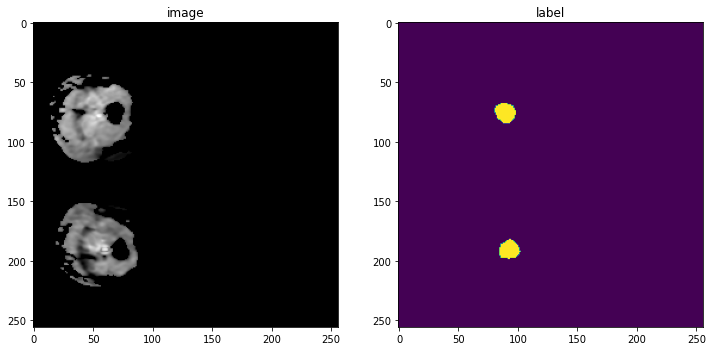

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


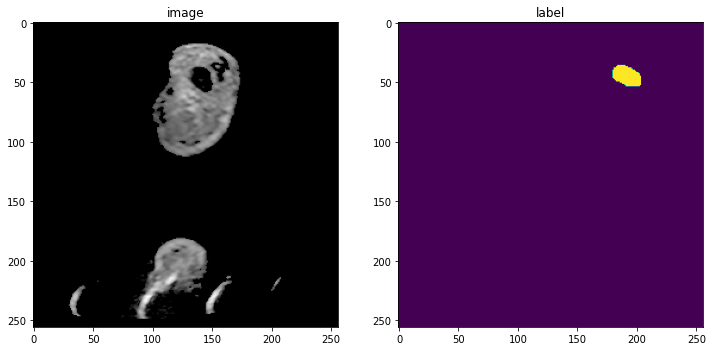

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


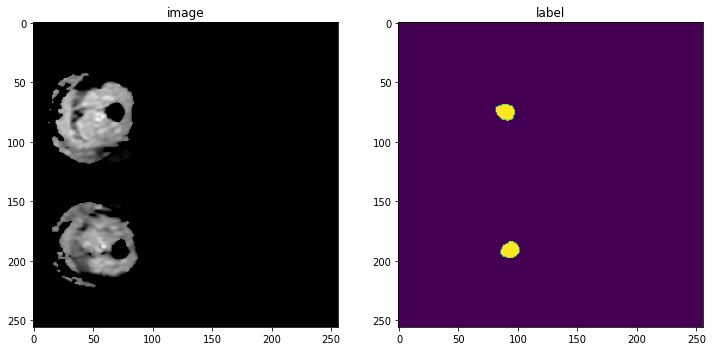

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


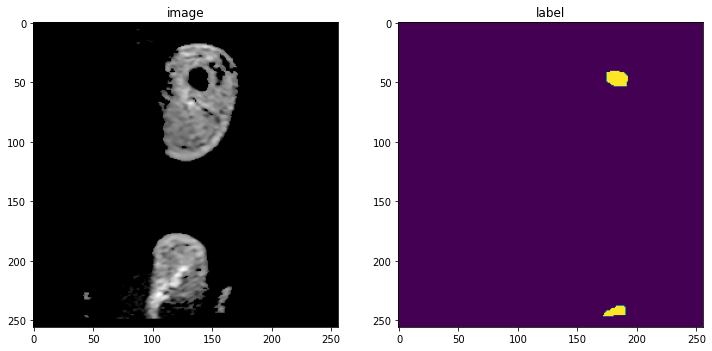

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


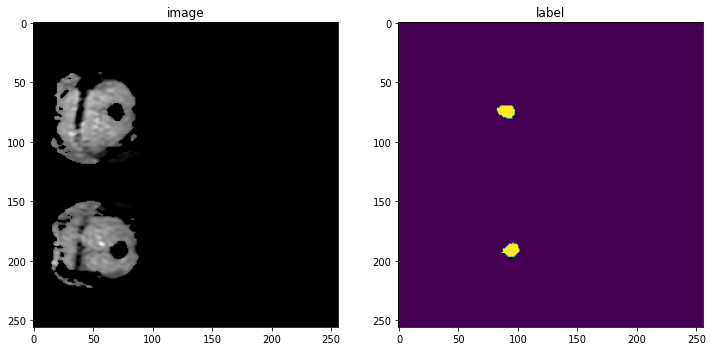

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


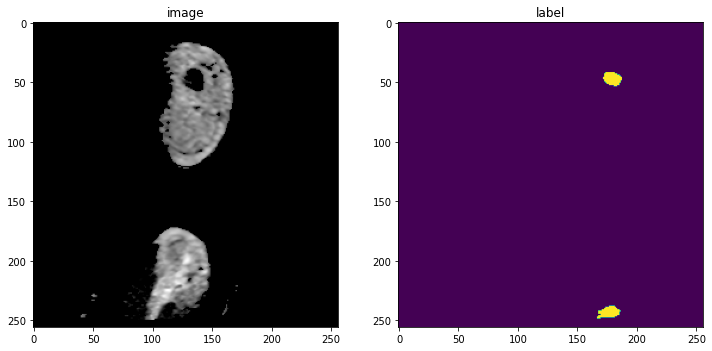

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


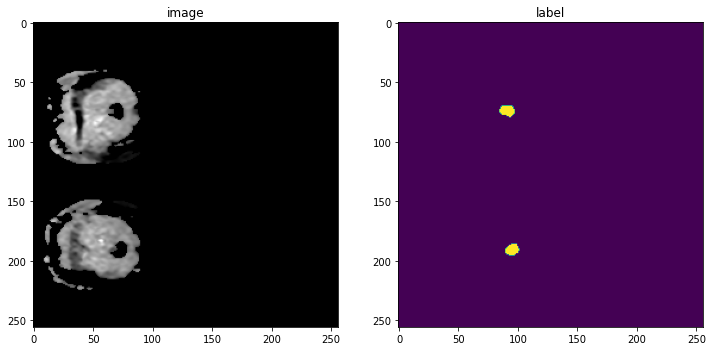

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


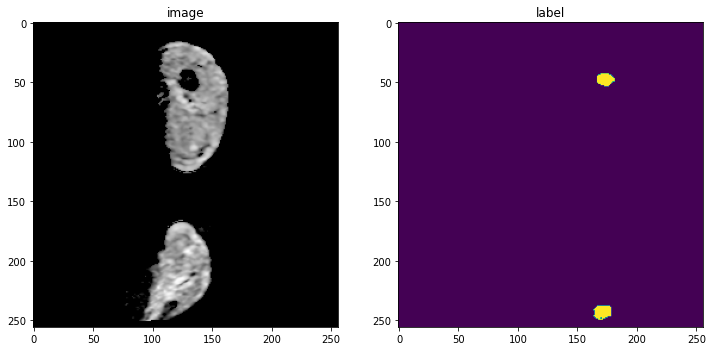

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


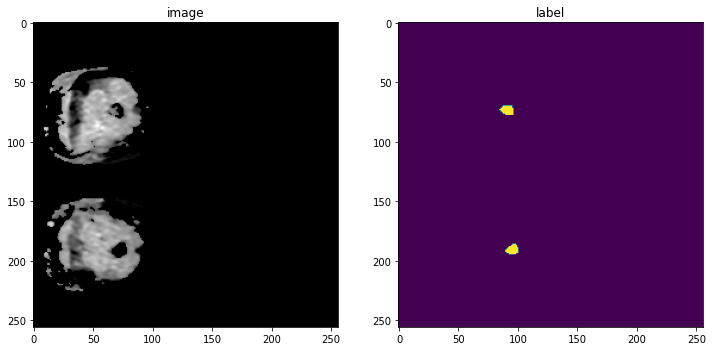

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


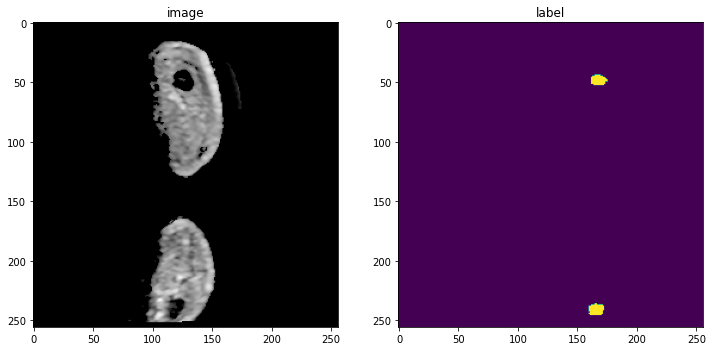

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


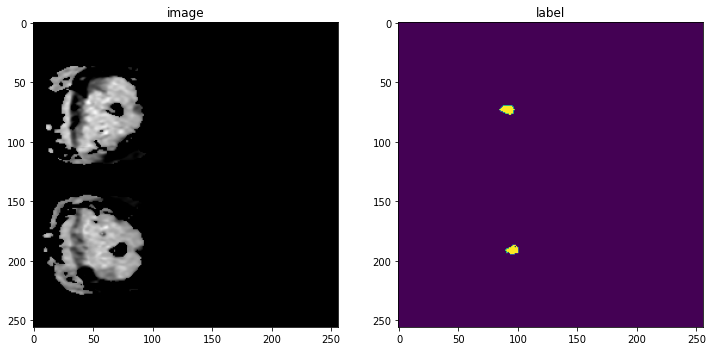

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


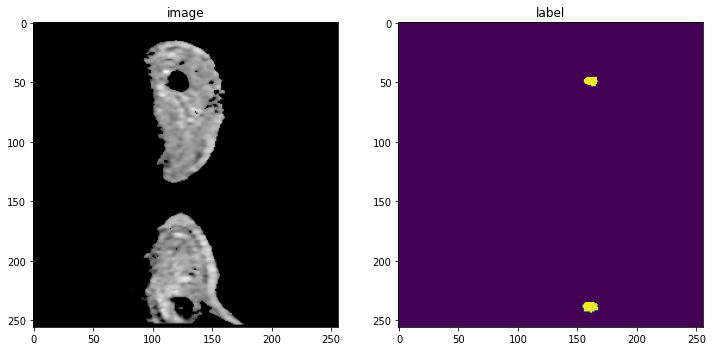

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


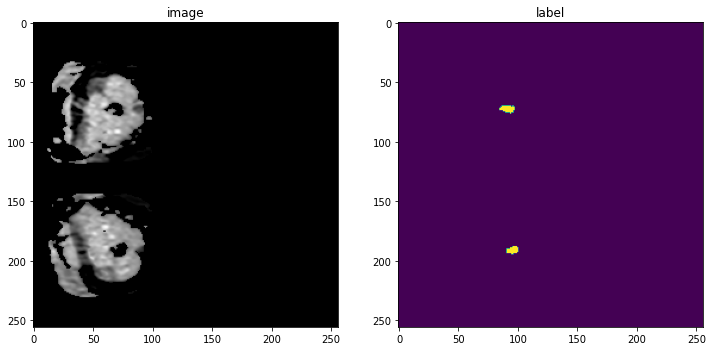

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


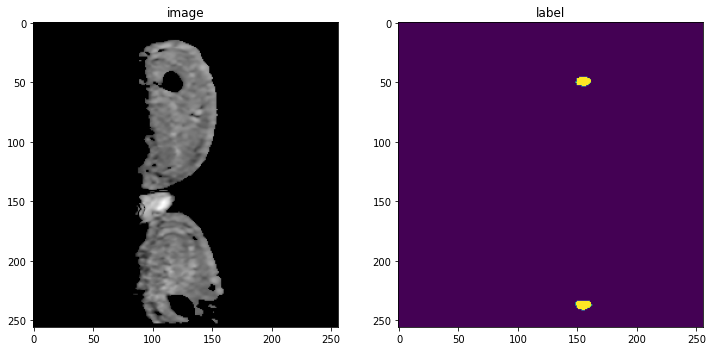

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


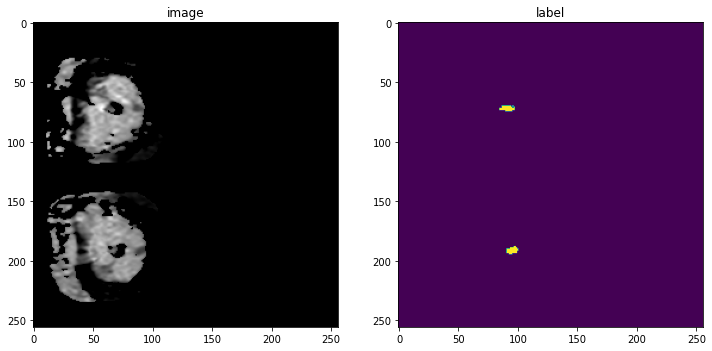

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


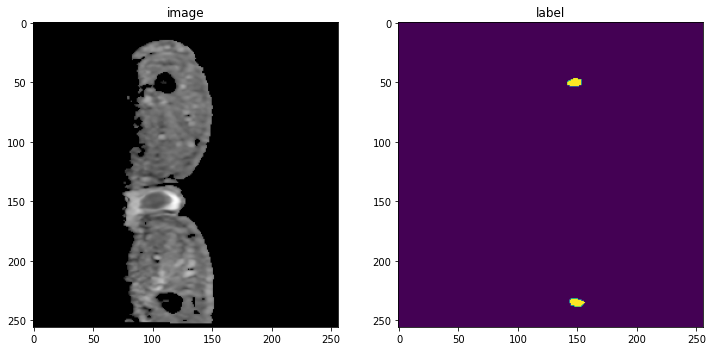

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


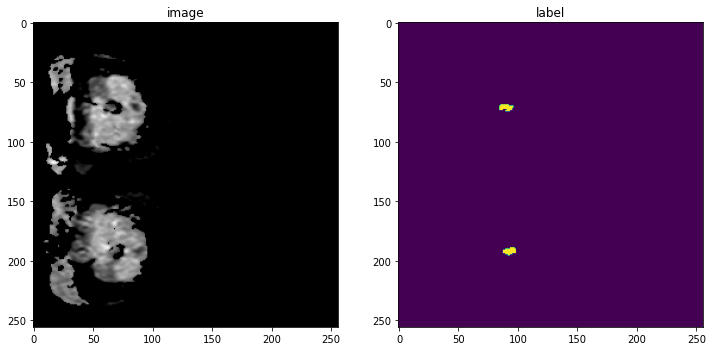

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


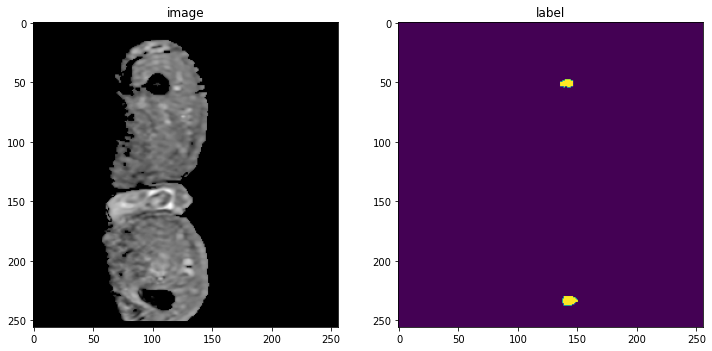

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


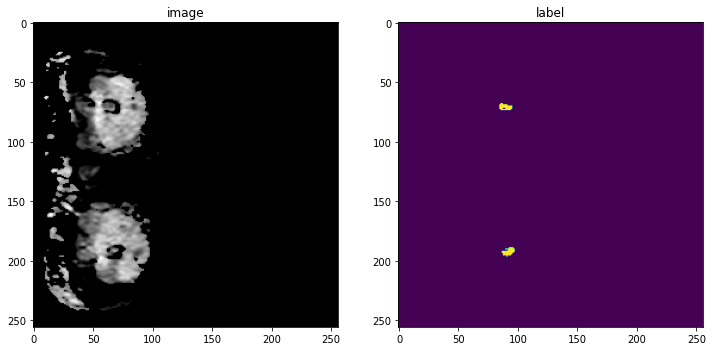

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


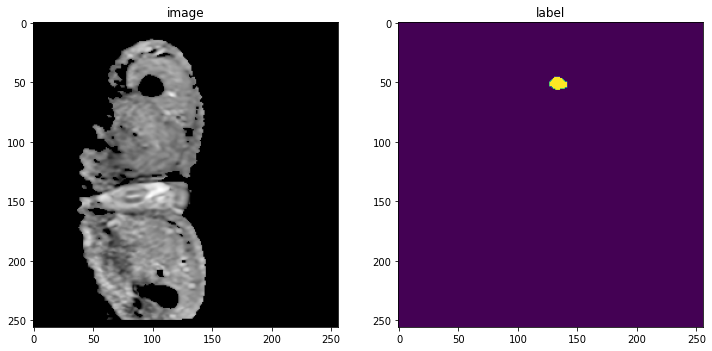

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


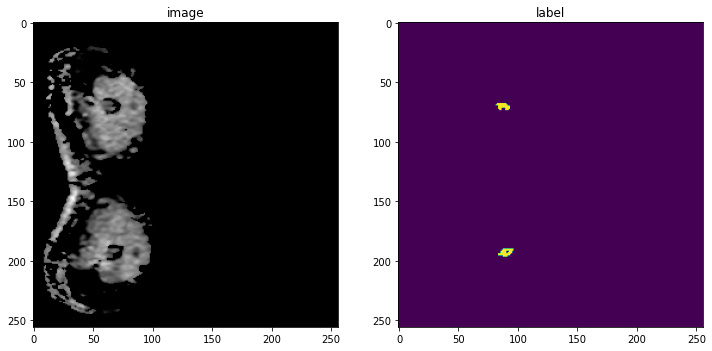

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


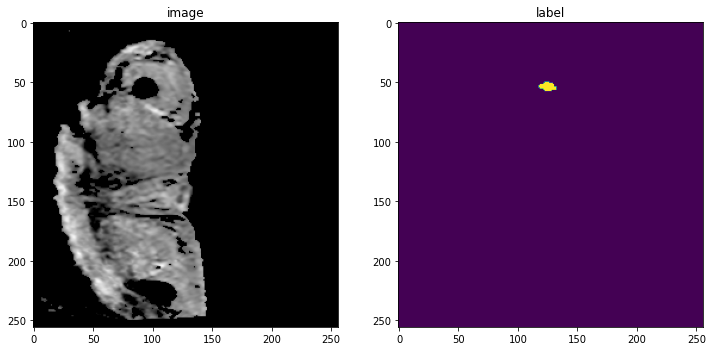

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


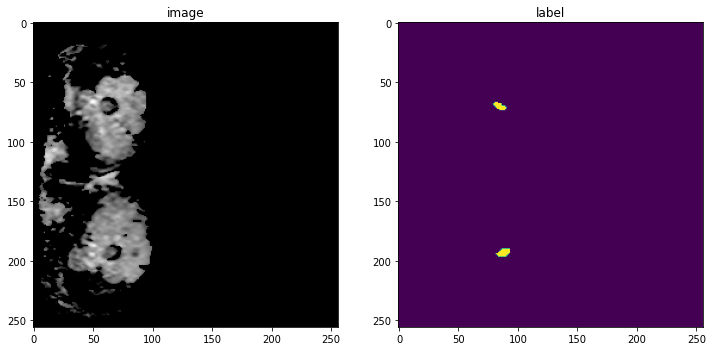

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


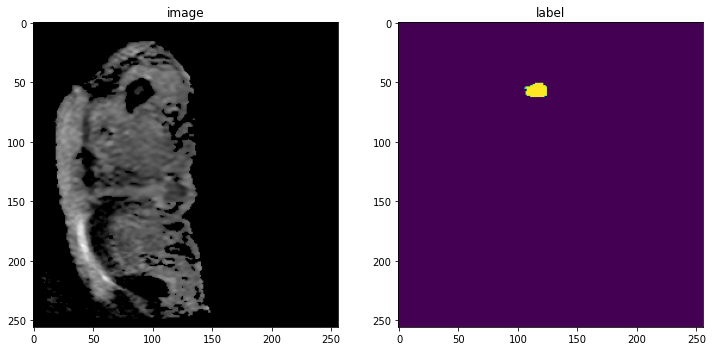

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


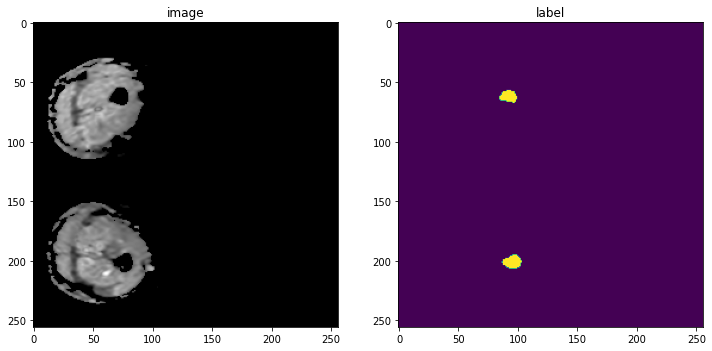

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


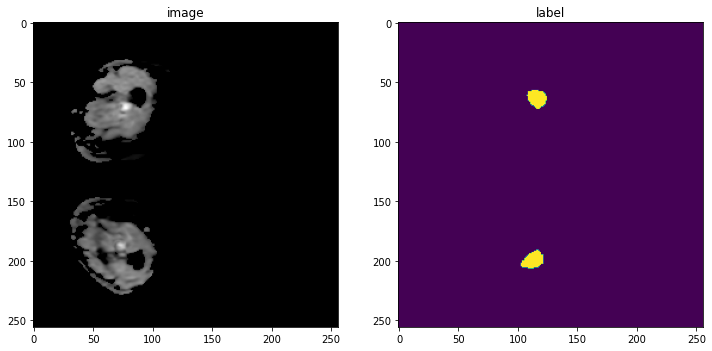

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


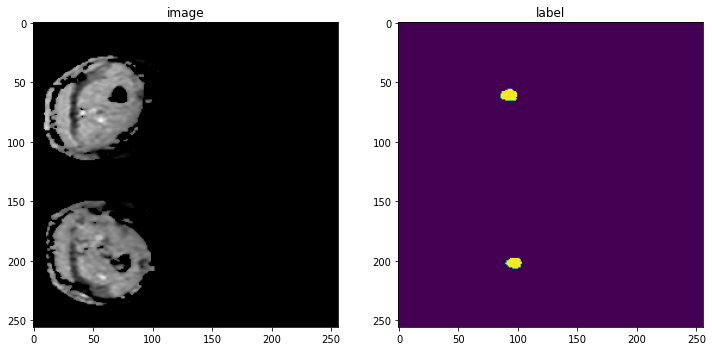

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


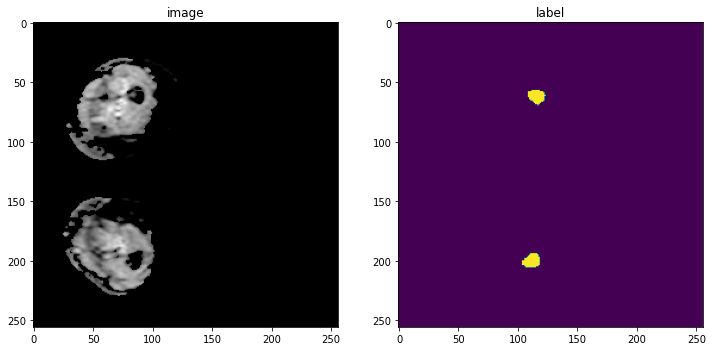

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


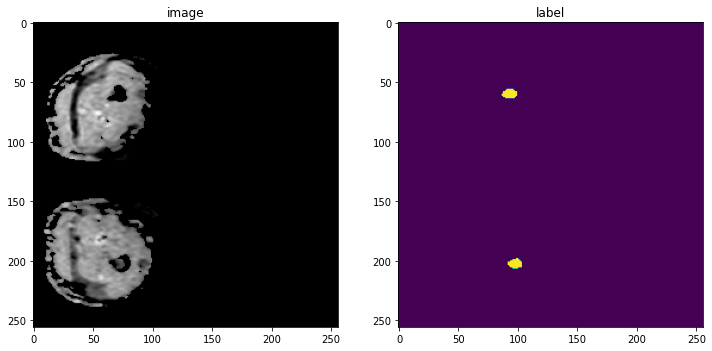

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


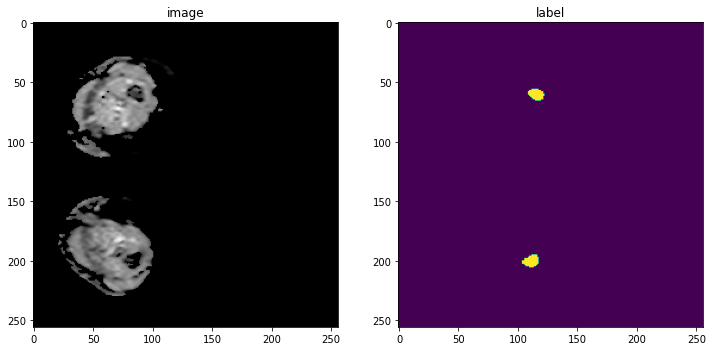

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


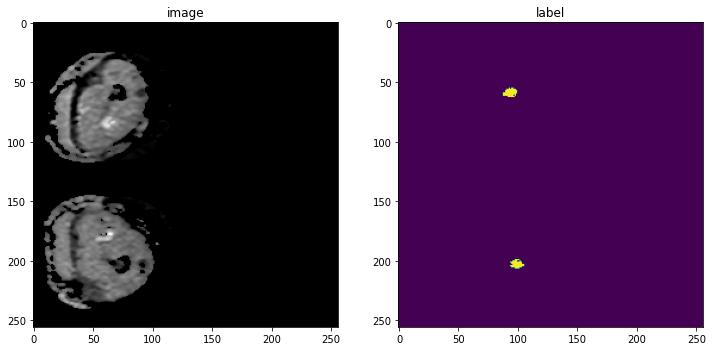

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


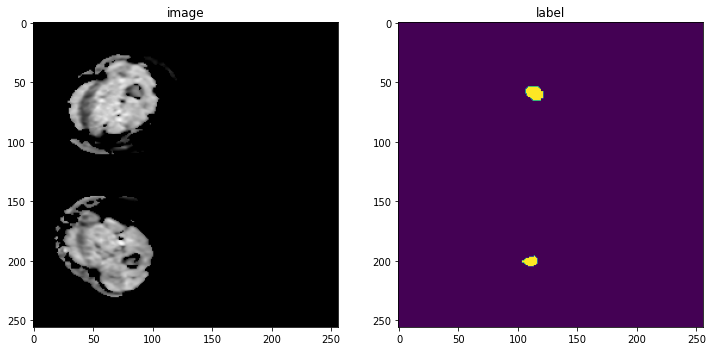

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


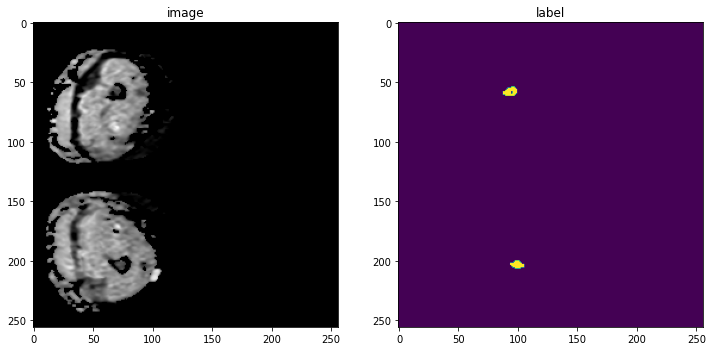

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


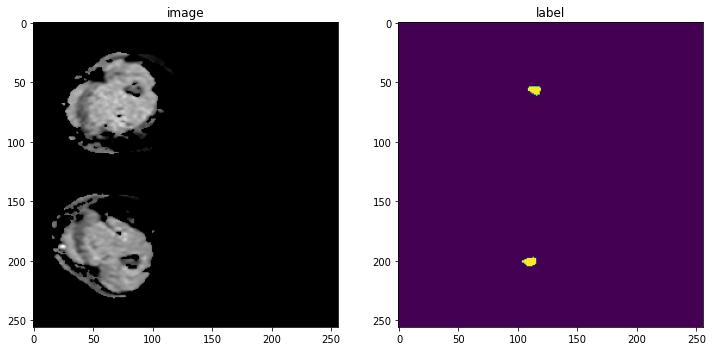

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


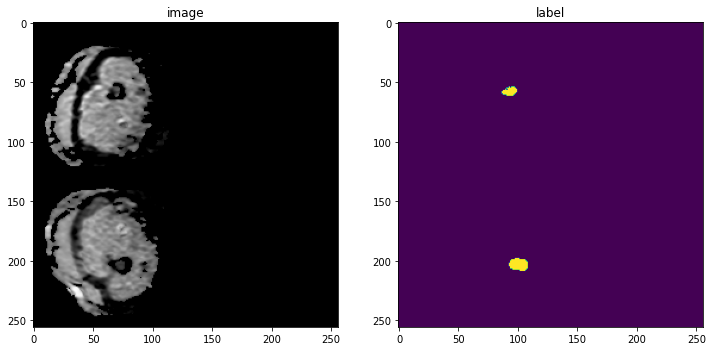

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


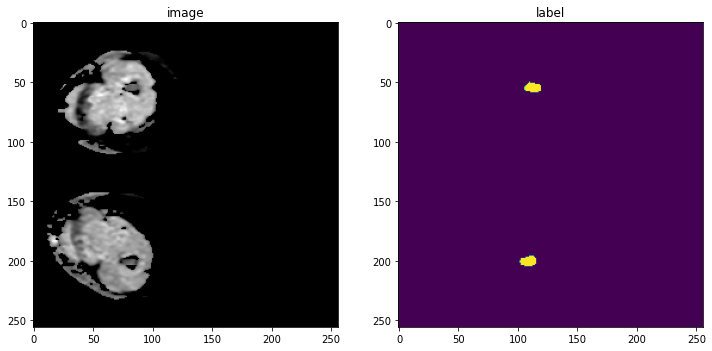

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


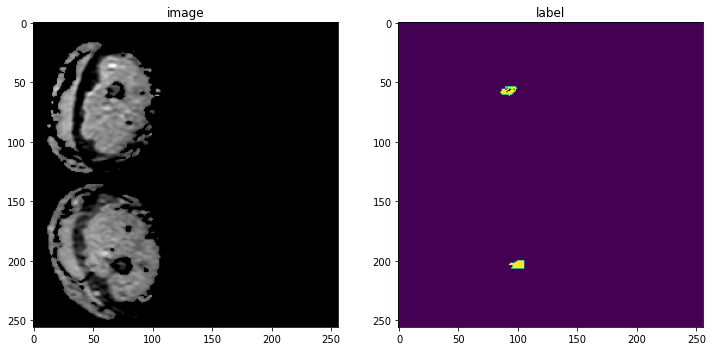

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


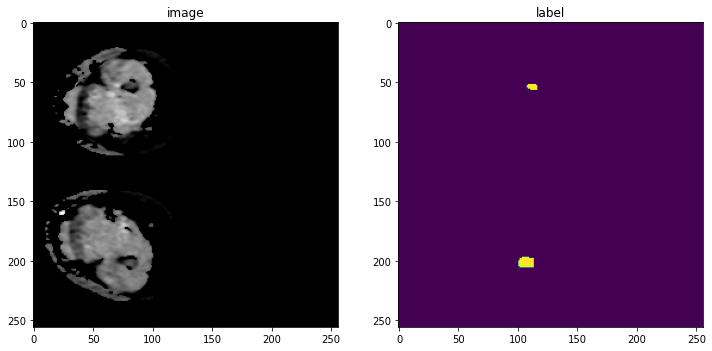

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


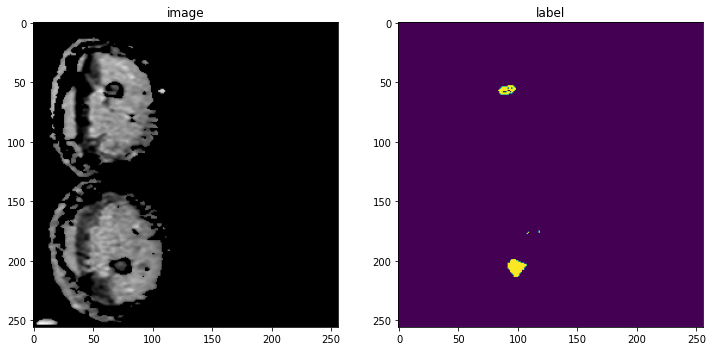

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


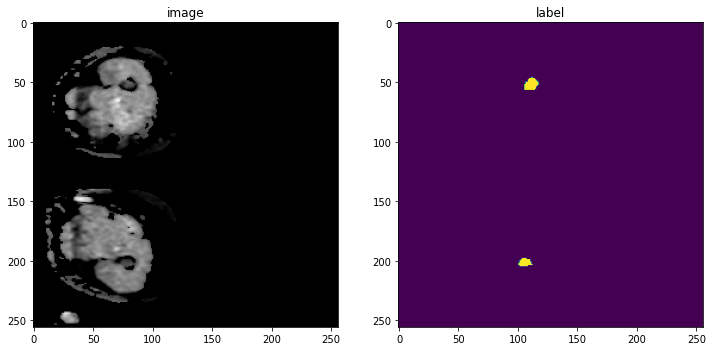

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


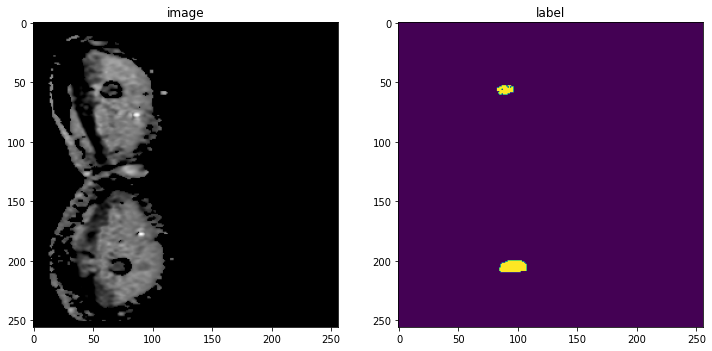

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


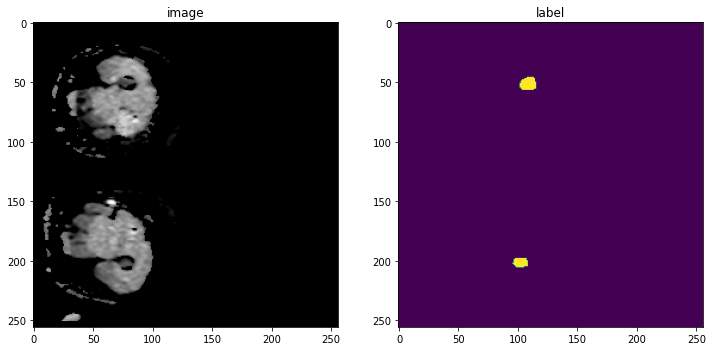

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


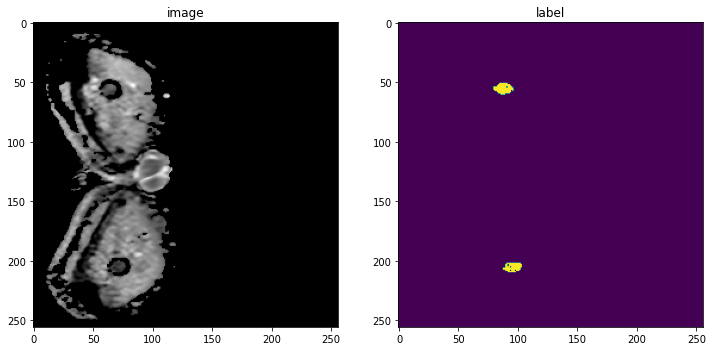

Exception in thread Thread-28:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/pin_memory.py", line 49, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/pin_memory.py", line 26, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 116, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.8/dist-packages/torch/multiprocessing/reductions.py", line 305, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.8/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.8/multiprocessing/reduction.py", line 189, in r

image shape: torch.Size([256, 256]), label shape: torch.Size([256, 256])


KeyboardInterrupt: ignored

In [ ]:
for check_data in val_loader:
  image, label = (check_data["image"][0][0], check_data["label"][0][0])
  print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
  plt.figure("check", (12, 6))
  plt.subplot(1, 2, 1)
  plt.title("image")
  plt.imshow(image, cmap="gray")
  plt.subplot(1, 2, 2)
  plt.title("label")
  plt.imshow(label)
  plt.show()

## Create Model, Loss, Optimizer

In [ ]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
#model = VNet(spatial_dims=3, in_channels=1, out_channels=2, act=('elu', {'inplace': True}), dropout_prob=0.5, dropout_dim=3).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 5*1e-5)
dice_metric = DiceMetric(include_background=False, reduction="mean")

## Execute a typical PyTorch training process

In [ ]:
from tqdm import tqdm

In [ ]:
max_epochs = 500
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in tqdm(range(max_epochs)):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

  0%|          | 0/500 [00:00<?, ?it/s]

----------
epoch 1/500
1/6, train_loss: 0.6729
2/6, train_loss: 0.6633
3/6, train_loss: 0.6700
4/6, train_loss: 0.6564
5/6, train_loss: 0.6687
6/6, train_loss: 0.6626
7/6, train_loss: 0.6681
8/6, train_loss: 0.6502
9/6, train_loss: 0.6677
10/6, train_loss: 0.6493
11/6, train_loss: 0.6674
12/6, train_loss: 0.6349
13/6, train_loss: 0.6672
14/6, train_loss: 0.6360
15/6, train_loss: 0.6672
16/6, train_loss: 0.6583
17/6, train_loss: 0.6674
18/6, train_loss: 0.6604
19/6, train_loss: 0.6672
20/6, train_loss: 0.6610
21/6, train_loss: 0.6670
22/6, train_loss: 0.6604
23/6, train_loss: 0.6656
24/6, train_loss: 0.6600
25/6, train_loss: 0.6568
26/6, train_loss: 0.6524
27/6, train_loss: 0.6574
28/6, train_loss: 0.6511
29/6, train_loss: 0.6573
30/6, train_loss: 0.6510
31/6, train_loss: 0.6573
32/6, train_loss: 0.6501
33/6, train_loss: 0.6570
34/6, train_loss: 0.6518
35/6, train_loss: 0.6572
36/6, train_loss: 0.6518
37/6, train_loss: 0.6572
38/6, train_loss: 0.6510
39/6, train_loss: 0.6566
40/6, train

  0%|          | 1/500 [00:39<5:28:32, 39.50s/it]

saved new best metric model
current epoch: 1 current mean dice: 0.0354
best mean dice: 0.0354 at epoch: 1
----------
epoch 2/500
1/6, train_loss: 0.6163
2/6, train_loss: 0.5860
3/6, train_loss: 0.6183
4/6, train_loss: 0.5810
5/6, train_loss: 0.6208
6/6, train_loss: 0.6007
7/6, train_loss: 0.6228
8/6, train_loss: 0.5826
9/6, train_loss: 0.6243
10/6, train_loss: 0.5848
11/6, train_loss: 0.6253
12/6, train_loss: 0.5672
13/6, train_loss: 0.6262
14/6, train_loss: 0.5719
15/6, train_loss: 0.6275
16/6, train_loss: 0.6107
17/6, train_loss: 0.6289
18/6, train_loss: 0.6163
19/6, train_loss: 0.6295
20/6, train_loss: 0.6190
21/6, train_loss: 0.6299
22/6, train_loss: 0.6198
23/6, train_loss: 0.6285
24/6, train_loss: 0.6208
25/6, train_loss: 0.6158
26/6, train_loss: 0.6101
27/6, train_loss: 0.6178
28/6, train_loss: 0.6098
29/6, train_loss: 0.6185
30/6, train_loss: 0.6099
31/6, train_loss: 0.6195
32/6, train_loss: 0.6098
33/6, train_loss: 0.6196
34/6, train_loss: 0.6133
35/6, train_loss: 0.6208
36/6,

  0%|          | 2/500 [01:10<4:46:46, 34.55s/it]

saved new best metric model
current epoch: 2 current mean dice: 0.0500
best mean dice: 0.0500 at epoch: 2
----------
epoch 3/500
1/6, train_loss: 0.5945
2/6, train_loss: 0.5641
3/6, train_loss: 0.5969
4/6, train_loss: 0.5590
5/6, train_loss: 0.5999
6/6, train_loss: 0.5787
7/6, train_loss: 0.6021
8/6, train_loss: 0.5577
9/6, train_loss: 0.6041
10/6, train_loss: 0.5613
11/6, train_loss: 0.6054
12/6, train_loss: 0.5412
13/6, train_loss: 0.6066
14/6, train_loss: 0.5451
15/6, train_loss: 0.6082
16/6, train_loss: 0.5895
17/6, train_loss: 0.6097
18/6, train_loss: 0.5968
19/6, train_loss: 0.6105
20/6, train_loss: 0.6005
21/6, train_loss: 0.6110
22/6, train_loss: 0.6017
23/6, train_loss: 0.6095
24/6, train_loss: 0.6030
25/6, train_loss: 0.5957
26/6, train_loss: 0.5894
27/6, train_loss: 0.5972
28/6, train_loss: 0.5876
29/6, train_loss: 0.5977
30/6, train_loss: 0.5872
31/6, train_loss: 0.5987
32/6, train_loss: 0.5869
33/6, train_loss: 0.5986
34/6, train_loss: 0.5914
35/6, train_loss: 0.5998
36/6,

  1%|          | 3/500 [01:41<4:31:46, 32.81s/it]

saved new best metric model
current epoch: 3 current mean dice: 0.0711
best mean dice: 0.0711 at epoch: 3
----------
epoch 4/500
1/6, train_loss: 0.5753
2/6, train_loss: 0.5404
3/6, train_loss: 0.5780
4/6, train_loss: 0.5359
5/6, train_loss: 0.5821
6/6, train_loss: 0.5557
7/6, train_loss: 0.5849
8/6, train_loss: 0.5310
9/6, train_loss: 0.5873
10/6, train_loss: 0.5362
11/6, train_loss: 0.5889
12/6, train_loss: 0.5133
13/6, train_loss: 0.5901
14/6, train_loss: 0.5181
15/6, train_loss: 0.5918
16/6, train_loss: 0.5705
17/6, train_loss: 0.5931
18/6, train_loss: 0.5797
19/6, train_loss: 0.5941
20/6, train_loss: 0.5842
21/6, train_loss: 0.5947
22/6, train_loss: 0.5855
23/6, train_loss: 0.5925
24/6, train_loss: 0.5870
25/6, train_loss: 0.5778
26/6, train_loss: 0.5698
27/6, train_loss: 0.5791
28/6, train_loss: 0.5674
29/6, train_loss: 0.5794
30/6, train_loss: 0.5670
31/6, train_loss: 0.5806
32/6, train_loss: 0.5666
33/6, train_loss: 0.5804
34/6, train_loss: 0.5720
35/6, train_loss: 0.5819
36/6,

  1%|          | 4/500 [02:12<4:25:06, 32.07s/it]

saved new best metric model
current epoch: 4 current mean dice: 0.0775
best mean dice: 0.0775 at epoch: 4
----------
epoch 5/500
1/6, train_loss: 0.5581
2/6, train_loss: 0.5175
3/6, train_loss: 0.5613
4/6, train_loss: 0.5119
5/6, train_loss: 0.5660
6/6, train_loss: 0.5346
7/6, train_loss: 0.5692
8/6, train_loss: 0.5063
9/6, train_loss: 0.5718
10/6, train_loss: 0.5135
11/6, train_loss: 0.5735
12/6, train_loss: 0.4878
13/6, train_loss: 0.5749
14/6, train_loss: 0.4936
15/6, train_loss: 0.5767
16/6, train_loss: 0.5528
17/6, train_loss: 0.5777
18/6, train_loss: 0.5635
19/6, train_loss: 0.5787
20/6, train_loss: 0.5687
21/6, train_loss: 0.5792
22/6, train_loss: 0.5702
23/6, train_loss: 0.5761
24/6, train_loss: 0.5718
25/6, train_loss: 0.5594
26/6, train_loss: 0.5504
27/6, train_loss: 0.5615
28/6, train_loss: 0.5487
29/6, train_loss: 0.5622
30/6, train_loss: 0.5483
31/6, train_loss: 0.5638
32/6, train_loss: 0.5482
33/6, train_loss: 0.5639
34/6, train_loss: 0.5544
35/6, train_loss: 0.5658
36/6,

  1%|          | 5/500 [02:43<4:22:29, 31.82s/it]

saved new best metric model
current epoch: 5 current mean dice: 0.0915
best mean dice: 0.0915 at epoch: 5
----------
epoch 6/500
1/6, train_loss: 0.5426
2/6, train_loss: 0.4968
3/6, train_loss: 0.5460
4/6, train_loss: 0.4849
5/6, train_loss: 0.5514
6/6, train_loss: 0.5138
7/6, train_loss: 0.5553
8/6, train_loss: 0.4805
9/6, train_loss: 0.5582
10/6, train_loss: 0.4899
11/6, train_loss: 0.5602
12/6, train_loss: 0.4608
13/6, train_loss: 0.5617
14/6, train_loss: 0.4684
15/6, train_loss: 0.5637
16/6, train_loss: 0.5367
17/6, train_loss: 0.5646
18/6, train_loss: 0.5487
19/6, train_loss: 0.5654
20/6, train_loss: 0.5545
21/6, train_loss: 0.5660
22/6, train_loss: 0.5560
23/6, train_loss: 0.5621
24/6, train_loss: 0.5578
25/6, train_loss: 0.5426
26/6, train_loss: 0.5329
27/6, train_loss: 0.5460
28/6, train_loss: 0.5315
29/6, train_loss: 0.5471
30/6, train_loss: 0.5313
31/6, train_loss: 0.5489
32/6, train_loss: 0.5312
33/6, train_loss: 0.5490
34/6, train_loss: 0.5383
35/6, train_loss: 0.5512
36/6,

  1%|          | 6/500 [03:15<4:21:05, 31.71s/it]

saved new best metric model
current epoch: 6 current mean dice: 0.1259
best mean dice: 0.1259 at epoch: 6
----------
epoch 7/500
1/6, train_loss: 0.5277
2/6, train_loss: 0.4712
3/6, train_loss: 0.5316
4/6, train_loss: 0.4599
5/6, train_loss: 0.5379
6/6, train_loss: 0.4939
7/6, train_loss: 0.5425
8/6, train_loss: 0.4587
9/6, train_loss: 0.5460
10/6, train_loss: 0.4669
11/6, train_loss: 0.5482
12/6, train_loss: 0.4334
13/6, train_loss: 0.5500
14/6, train_loss: 0.4437
15/6, train_loss: 0.5522
16/6, train_loss: 0.5215
17/6, train_loss: 0.5530
18/6, train_loss: 0.5352
19/6, train_loss: 0.5537
20/6, train_loss: 0.5416
21/6, train_loss: 0.5544
22/6, train_loss: 0.5429
23/6, train_loss: 0.5502
24/6, train_loss: 0.5452
25/6, train_loss: 0.5272
26/6, train_loss: 0.5162
27/6, train_loss: 0.5318
28/6, train_loss: 0.5152
29/6, train_loss: 0.5332
30/6, train_loss: 0.5149
31/6, train_loss: 0.5354
32/6, train_loss: 0.5149
33/6, train_loss: 0.5355
34/6, train_loss: 0.5232
35/6, train_loss: 0.5381
36/6,

  1%|▏         | 7/500 [03:45<4:17:39, 31.36s/it]

saved new best metric model
current epoch: 7 current mean dice: 0.1620
best mean dice: 0.1620 at epoch: 7
----------
epoch 8/500
1/6, train_loss: 0.5128
2/6, train_loss: 0.4335
3/6, train_loss: 0.5180
4/6, train_loss: 0.4272
5/6, train_loss: 0.5255
6/6, train_loss: 0.4695
7/6, train_loss: 0.5306
8/6, train_loss: 0.4253
9/6, train_loss: 0.5348
10/6, train_loss: 0.4371
11/6, train_loss: 0.5372
12/6, train_loss: 0.4079
13/6, train_loss: 0.5390
14/6, train_loss: 0.4164
15/6, train_loss: 0.5412
16/6, train_loss: 0.5031
17/6, train_loss: 0.5418
18/6, train_loss: 0.5189
19/6, train_loss: 0.5422
20/6, train_loss: 0.5267
21/6, train_loss: 0.5424
22/6, train_loss: 0.5288
23/6, train_loss: 0.5364
24/6, train_loss: 0.5324
25/6, train_loss: 0.5119
26/6, train_loss: 0.4995
27/6, train_loss: 0.5172
28/6, train_loss: 0.4985
29/6, train_loss: 0.5193
30/6, train_loss: 0.4979
31/6, train_loss: 0.5220
32/6, train_loss: 0.4981
33/6, train_loss: 0.5222
34/6, train_loss: 0.5080
35/6, train_loss: 0.5251
36/6,

  2%|▏         | 8/500 [04:16<4:16:38, 31.30s/it]

saved new best metric model
current epoch: 8 current mean dice: 0.2703
best mean dice: 0.2703 at epoch: 8
----------
epoch 9/500
1/6, train_loss: 0.4950
2/6, train_loss: 0.4056
3/6, train_loss: 0.5017
4/6, train_loss: 0.3994
5/6, train_loss: 0.5107
6/6, train_loss: 0.4463
7/6, train_loss: 0.5169
8/6, train_loss: 0.3955
9/6, train_loss: 0.5216
10/6, train_loss: 0.4104
11/6, train_loss: 0.5244
12/6, train_loss: 0.3703
13/6, train_loss: 0.5265
14/6, train_loss: 0.3827
15/6, train_loss: 0.5291
16/6, train_loss: 0.4867
17/6, train_loss: 0.5296
18/6, train_loss: 0.5044
19/6, train_loss: 0.5301
20/6, train_loss: 0.5131
21/6, train_loss: 0.5303
22/6, train_loss: 0.5157
23/6, train_loss: 0.5235
24/6, train_loss: 0.5201
25/6, train_loss: 0.4924
26/6, train_loss: 0.4780
27/6, train_loss: 0.4998
28/6, train_loss: 0.4772
29/6, train_loss: 0.5020
30/6, train_loss: 0.4763
31/6, train_loss: 0.5053
32/6, train_loss: 0.4762
33/6, train_loss: 0.5056
34/6, train_loss: 0.4884
35/6, train_loss: 0.5092
36/6,

  2%|▏         | 9/500 [04:48<4:16:26, 31.34s/it]

saved new best metric model
current epoch: 9 current mean dice: 0.3491
best mean dice: 0.3491 at epoch: 9
----------
epoch 10/500
1/6, train_loss: 0.4771
2/6, train_loss: 0.3698
3/6, train_loss: 0.4842
4/6, train_loss: 0.3606
5/6, train_loss: 0.4953
6/6, train_loss: 0.4159
7/6, train_loss: 0.5029
8/6, train_loss: 0.3588
9/6, train_loss: 0.5089
10/6, train_loss: 0.3776
11/6, train_loss: 0.5125
12/6, train_loss: 0.3356
13/6, train_loss: 0.5151
14/6, train_loss: 0.3479
15/6, train_loss: 0.5184
16/6, train_loss: 0.4649
17/6, train_loss: 0.5190
18/6, train_loss: 0.4874
19/6, train_loss: 0.5196
20/6, train_loss: 0.4980
21/6, train_loss: 0.5211
22/6, train_loss: 0.5016
23/6, train_loss: 0.5130
24/6, train_loss: 0.5073
25/6, train_loss: 0.4724
26/6, train_loss: 0.4545
27/6, train_loss: 0.4818
28/6, train_loss: 0.4536
29/6, train_loss: 0.4845
30/6, train_loss: 0.4527
31/6, train_loss: 0.4887
32/6, train_loss: 0.4526
33/6, train_loss: 0.4890
34/6, train_loss: 0.4678
35/6, train_loss: 0.4934
36/6

  2%|▏         | 10/500 [05:18<4:14:05, 31.11s/it]

saved new best metric model
current epoch: 10 current mean dice: 0.4006
best mean dice: 0.4006 at epoch: 10
----------
epoch 11/500
1/6, train_loss: 0.4557
2/6, train_loss: 0.3299
3/6, train_loss: 0.4652
4/6, train_loss: 0.3298
5/6, train_loss: 0.4794
6/6, train_loss: 0.3840
7/6, train_loss: 0.4892
8/6, train_loss: 0.3196
9/6, train_loss: 0.4966
10/6, train_loss: 0.3455
11/6, train_loss: 0.5012
12/6, train_loss: 0.2963
13/6, train_loss: 0.5045
14/6, train_loss: 0.3093
15/6, train_loss: 0.5086
16/6, train_loss: 0.4415
17/6, train_loss: 0.5088
18/6, train_loss: 0.4675
19/6, train_loss: 0.5093
20/6, train_loss: 0.4817
21/6, train_loss: 0.5101
22/6, train_loss: 0.4869
23/6, train_loss: 0.4993
24/6, train_loss: 0.4946
25/6, train_loss: 0.4523
26/6, train_loss: 0.4334
27/6, train_loss: 0.4630
28/6, train_loss: 0.4286
29/6, train_loss: 0.4664
30/6, train_loss: 0.4268
31/6, train_loss: 0.4713
32/6, train_loss: 0.4266
33/6, train_loss: 0.4719
34/6, train_loss: 0.4457
35/6, train_loss: 0.4775
36

  2%|▏         | 11/500 [05:50<4:15:01, 31.29s/it]

saved new best metric model
current epoch: 11 current mean dice: 0.4177
best mean dice: 0.4177 at epoch: 11
----------
epoch 12/500
1/6, train_loss: 0.4321
2/6, train_loss: 0.2912
3/6, train_loss: 0.4437
4/6, train_loss: 0.2939
5/6, train_loss: 0.4614
6/6, train_loss: 0.3508
7/6, train_loss: 0.4735
8/6, train_loss: 0.2792
9/6, train_loss: 0.4832
10/6, train_loss: 0.3069
11/6, train_loss: 0.4889
12/6, train_loss: 0.2597
13/6, train_loss: 0.4930
14/6, train_loss: 0.2767
15/6, train_loss: 0.4982
16/6, train_loss: 0.4101
17/6, train_loss: 0.4984
18/6, train_loss: 0.4426
19/6, train_loss: 0.4989
20/6, train_loss: 0.4632
21/6, train_loss: 0.4986
22/6, train_loss: 0.4701
23/6, train_loss: 0.4847
24/6, train_loss: 0.4806
25/6, train_loss: 0.4316
26/6, train_loss: 0.4078
27/6, train_loss: 0.4395
28/6, train_loss: 0.3982
29/6, train_loss: 0.4447
30/6, train_loss: 0.3977
31/6, train_loss: 0.4513
32/6, train_loss: 0.3982
33/6, train_loss: 0.4522
34/6, train_loss: 0.4197
35/6, train_loss: 0.4594
36

  2%|▏         | 12/500 [06:21<4:14:00, 31.23s/it]

current epoch: 12 current mean dice: 0.3953
best mean dice: 0.4177 at epoch: 11
----------
epoch 13/500
1/6, train_loss: 0.4046
2/6, train_loss: 0.2494
3/6, train_loss: 0.4186
4/6, train_loss: 0.2511
5/6, train_loss: 0.4406
6/6, train_loss: 0.3150
7/6, train_loss: 0.4572
8/6, train_loss: 0.2390
9/6, train_loss: 0.4682
10/6, train_loss: 0.2678
11/6, train_loss: 0.4759
12/6, train_loss: 0.2246
13/6, train_loss: 0.4814
14/6, train_loss: 0.2396
15/6, train_loss: 0.4885
16/6, train_loss: 0.3787
17/6, train_loss: 0.4888
18/6, train_loss: 0.4151
19/6, train_loss: 0.4895
20/6, train_loss: 0.4420
21/6, train_loss: 0.4902
22/6, train_loss: 0.4514
23/6, train_loss: 0.4713
24/6, train_loss: 0.4650
25/6, train_loss: 0.4025
26/6, train_loss: 0.3693
27/6, train_loss: 0.4132
28/6, train_loss: 0.3604
29/6, train_loss: 0.4188
30/6, train_loss: 0.3617
31/6, train_loss: 0.4276
32/6, train_loss: 0.3634
33/6, train_loss: 0.4281
34/6, train_loss: 0.3882
35/6, train_loss: 0.4372
36/6, train_loss: 0.3972
37/6,

  3%|▎         | 13/500 [06:53<4:13:40, 31.25s/it]

saved new best metric model
current epoch: 13 current mean dice: 0.4512
best mean dice: 0.4512 at epoch: 13
----------
epoch 14/500
1/6, train_loss: 0.3802
2/6, train_loss: 0.2245
3/6, train_loss: 0.3900
4/6, train_loss: 0.2346
5/6, train_loss: 0.4148
6/6, train_loss: 0.2753
7/6, train_loss: 0.4356
8/6, train_loss: 0.2145
9/6, train_loss: 0.4506
10/6, train_loss: 0.2416
11/6, train_loss: 0.4606
12/6, train_loss: 0.1863
13/6, train_loss: 0.4682
14/6, train_loss: 0.2027
15/6, train_loss: 0.4774
16/6, train_loss: 0.3489
17/6, train_loss: 0.4782
18/6, train_loss: 0.3864
19/6, train_loss: 0.4792
20/6, train_loss: 0.4180
21/6, train_loss: 0.4795
22/6, train_loss: 0.4296
23/6, train_loss: 0.4570
24/6, train_loss: 0.4471
25/6, train_loss: 0.3631
26/6, train_loss: 0.3463
27/6, train_loss: 0.3795
28/6, train_loss: 0.3234
29/6, train_loss: 0.3860
30/6, train_loss: 0.3238
31/6, train_loss: 0.3964
32/6, train_loss: 0.3272
33/6, train_loss: 0.3985
34/6, train_loss: 0.3523
35/6, train_loss: 0.4107
36

  3%|▎         | 14/500 [07:24<4:12:49, 31.21s/it]

current epoch: 14 current mean dice: 0.4300
best mean dice: 0.4512 at epoch: 13
----------
epoch 15/500
1/6, train_loss: 0.3323
2/6, train_loss: 0.1746
3/6, train_loss: 0.3511
4/6, train_loss: 0.1835
5/6, train_loss: 0.3834
6/6, train_loss: 0.2312
7/6, train_loss: 0.4094
8/6, train_loss: 0.1633
9/6, train_loss: 0.4289
10/6, train_loss: 0.2039
11/6, train_loss: 0.4422
12/6, train_loss: 0.1592
13/6, train_loss: 0.4519
14/6, train_loss: 0.1734
15/6, train_loss: 0.4645
16/6, train_loss: 0.2986
17/6, train_loss: 0.4647
18/6, train_loss: 0.3446
19/6, train_loss: 0.4661
20/6, train_loss: 0.3859
21/6, train_loss: 0.4659
22/6, train_loss: 0.4012
23/6, train_loss: 0.4350
24/6, train_loss: 0.4238
25/6, train_loss: 0.3295
26/6, train_loss: 0.2915
27/6, train_loss: 0.3443
28/6, train_loss: 0.2799
29/6, train_loss: 0.3507
30/6, train_loss: 0.2739
31/6, train_loss: 0.3629
32/6, train_loss: 0.2736
33/6, train_loss: 0.3639
34/6, train_loss: 0.3103
35/6, train_loss: 0.3787
36/6, train_loss: 0.3227
37/6,

  3%|▎         | 15/500 [07:56<4:15:34, 31.62s/it]

saved new best metric model
current epoch: 15 current mean dice: 0.4653
best mean dice: 0.4653 at epoch: 15
----------
epoch 16/500
1/6, train_loss: 0.3009
2/6, train_loss: 0.1512
3/6, train_loss: 0.3127
4/6, train_loss: 0.1507
5/6, train_loss: 0.3473
6/6, train_loss: 0.2054
7/6, train_loss: 0.3771
8/6, train_loss: 0.1314
9/6, train_loss: 0.4029
10/6, train_loss: 0.1785
11/6, train_loss: 0.4195
12/6, train_loss: 0.1392
13/6, train_loss: 0.4319
14/6, train_loss: 0.1471
15/6, train_loss: 0.4484
16/6, train_loss: 0.2626
17/6, train_loss: 0.4495
18/6, train_loss: 0.3079
19/6, train_loss: 0.4513
20/6, train_loss: 0.3536
21/6, train_loss: 0.4498
22/6, train_loss: 0.3716
23/6, train_loss: 0.4095
24/6, train_loss: 0.3987
25/6, train_loss: 0.3182
26/6, train_loss: 0.2585
27/6, train_loss: 0.3125
28/6, train_loss: 0.2431
29/6, train_loss: 0.3116
30/6, train_loss: 0.2365
31/6, train_loss: 0.3250
32/6, train_loss: 0.2327
33/6, train_loss: 0.3263
34/6, train_loss: 0.2680
35/6, train_loss: 0.3453
36

  3%|▎         | 16/500 [08:28<4:16:20, 31.78s/it]

current epoch: 16 current mean dice: 0.4551
best mean dice: 0.4653 at epoch: 15
----------
epoch 17/500
1/6, train_loss: 0.2517
2/6, train_loss: 0.1300
3/6, train_loss: 0.2700
4/6, train_loss: 0.1348
5/6, train_loss: 0.3089
6/6, train_loss: 0.1717
7/6, train_loss: 0.3402
8/6, train_loss: 0.1091
9/6, train_loss: 0.3743
10/6, train_loss: 0.1545
11/6, train_loss: 0.3953
12/6, train_loss: 0.1225
13/6, train_loss: 0.4107
14/6, train_loss: 0.1287
15/6, train_loss: 0.4312
16/6, train_loss: 0.2279
17/6, train_loss: 0.4307
18/6, train_loss: 0.2634
19/6, train_loss: 0.4305
20/6, train_loss: 0.3154
21/6, train_loss: 0.4283
22/6, train_loss: 0.3353
23/6, train_loss: 0.3903
24/6, train_loss: 0.3681
25/6, train_loss: 0.3354
26/6, train_loss: 0.2372
27/6, train_loss: 0.3055
28/6, train_loss: 0.2282
29/6, train_loss: 0.2694
30/6, train_loss: 0.2083
31/6, train_loss: 0.2845
32/6, train_loss: 0.1939
33/6, train_loss: 0.2867
34/6, train_loss: 0.2264
35/6, train_loss: 0.3116
36/6, train_loss: 0.2418
37/6,

  3%|▎         | 17/500 [09:01<4:16:46, 31.90s/it]

saved new best metric model
current epoch: 17 current mean dice: 0.4718
best mean dice: 0.4718 at epoch: 17
----------
epoch 18/500
1/6, train_loss: 0.2168
2/6, train_loss: 0.1066
3/6, train_loss: 0.2311
4/6, train_loss: 0.1312
5/6, train_loss: 0.2676
6/6, train_loss: 0.1573
7/6, train_loss: 0.2966
8/6, train_loss: 0.0930
9/6, train_loss: 0.3375
10/6, train_loss: 0.1380
11/6, train_loss: 0.3635
12/6, train_loss: 0.1159
13/6, train_loss: 0.3844
14/6, train_loss: 0.1183
15/6, train_loss: 0.4105
16/6, train_loss: 0.1953
17/6, train_loss: 0.4124
18/6, train_loss: 0.2315
19/6, train_loss: 0.4171
20/6, train_loss: 0.2780
21/6, train_loss: 0.4184
22/6, train_loss: 0.3000
23/6, train_loss: 0.3573
24/6, train_loss: 0.3303
25/6, train_loss: 0.2458
26/6, train_loss: 0.2172
27/6, train_loss: 0.2483
28/6, train_loss: 0.1959
29/6, train_loss: 0.2438
30/6, train_loss: 0.1712
31/6, train_loss: 0.2519
32/6, train_loss: 0.1628
33/6, train_loss: 0.2456
34/6, train_loss: 0.1910
35/6, train_loss: 0.2707
36

  4%|▎         | 18/500 [09:33<4:17:12, 32.02s/it]

saved new best metric model
current epoch: 18 current mean dice: 0.4886
best mean dice: 0.4886 at epoch: 18
----------
epoch 19/500
1/6, train_loss: 0.1921
2/6, train_loss: 0.1084
3/6, train_loss: 0.1983
4/6, train_loss: 0.1240
5/6, train_loss: 0.2232
6/6, train_loss: 0.1297
7/6, train_loss: 0.2664
8/6, train_loss: 0.0782
9/6, train_loss: 0.3101
10/6, train_loss: 0.1410
11/6, train_loss: 0.3400
12/6, train_loss: 0.1056
13/6, train_loss: 0.3622
14/6, train_loss: 0.1139
15/6, train_loss: 0.3913
16/6, train_loss: 0.1908
17/6, train_loss: 0.3903
18/6, train_loss: 0.1993
19/6, train_loss: 0.3930
20/6, train_loss: 0.2416
21/6, train_loss: 0.3924
22/6, train_loss: 0.2716
23/6, train_loss: 0.3239
24/6, train_loss: 0.2986
25/6, train_loss: 0.2139
26/6, train_loss: 0.1965
27/6, train_loss: 0.2175
28/6, train_loss: 0.1928
29/6, train_loss: 0.2181
30/6, train_loss: 0.1795
31/6, train_loss: 0.2189
32/6, train_loss: 0.1528
33/6, train_loss: 0.2058
34/6, train_loss: 0.1582
35/6, train_loss: 0.2279
36

  4%|▍         | 19/500 [10:05<4:16:51, 32.04s/it]

current epoch: 19 current mean dice: 0.4754
best mean dice: 0.4886 at epoch: 18
----------
epoch 20/500
1/6, train_loss: 0.1469
2/6, train_loss: 0.1015
3/6, train_loss: 0.1603
4/6, train_loss: 0.1453
5/6, train_loss: 0.1993
6/6, train_loss: 0.1186
7/6, train_loss: 0.2361
8/6, train_loss: 0.0706
9/6, train_loss: 0.2920
10/6, train_loss: 0.1092
11/6, train_loss: 0.3155
12/6, train_loss: 0.1043
13/6, train_loss: 0.3373
14/6, train_loss: 0.1052
15/6, train_loss: 0.3709
16/6, train_loss: 0.1508
17/6, train_loss: 0.3689
18/6, train_loss: 0.1602
19/6, train_loss: 0.3738
20/6, train_loss: 0.2077
21/6, train_loss: 0.3764
22/6, train_loss: 0.2366
23/6, train_loss: 0.2993
24/6, train_loss: 0.2818
25/6, train_loss: 0.1841
26/6, train_loss: 0.1839
27/6, train_loss: 0.1910
28/6, train_loss: 0.1695
29/6, train_loss: 0.1894
30/6, train_loss: 0.1481
31/6, train_loss: 0.1926
32/6, train_loss: 0.1340
33/6, train_loss: 0.1751
34/6, train_loss: 0.1308
35/6, train_loss: 0.1935
36/6, train_loss: 0.1413
37/6,

  4%|▍         | 20/500 [10:37<4:16:59, 32.12s/it]

saved new best metric model
current epoch: 20 current mean dice: 0.4988
best mean dice: 0.4988 at epoch: 20
----------
epoch 21/500
1/6, train_loss: 0.1454
2/6, train_loss: 0.1220
3/6, train_loss: 0.1536
4/6, train_loss: 0.1572
5/6, train_loss: 0.1815
6/6, train_loss: 0.1079
7/6, train_loss: 0.1981
8/6, train_loss: 0.0744
9/6, train_loss: 0.2524
10/6, train_loss: 0.1099
11/6, train_loss: 0.2844
12/6, train_loss: 0.1013
13/6, train_loss: 0.3141
14/6, train_loss: 0.1038
15/6, train_loss: 0.3552
16/6, train_loss: 0.1313
17/6, train_loss: 0.3509
18/6, train_loss: 0.1541
19/6, train_loss: 0.3563
20/6, train_loss: 0.1805
21/6, train_loss: 0.3637
22/6, train_loss: 0.2144
23/6, train_loss: 0.2848
24/6, train_loss: 0.2411
25/6, train_loss: 0.1600
26/6, train_loss: 0.1229
27/6, train_loss: 0.1759
28/6, train_loss: 0.1187
29/6, train_loss: 0.1761
30/6, train_loss: 0.1236
31/6, train_loss: 0.1811
32/6, train_loss: 0.1169
33/6, train_loss: 0.1633
34/6, train_loss: 0.1147
35/6, train_loss: 0.1644
36

  4%|▍         | 21/500 [11:10<4:17:14, 32.22s/it]

saved new best metric model
current epoch: 21 current mean dice: 0.5086
best mean dice: 0.5086 at epoch: 21
----------
epoch 22/500
1/6, train_loss: 0.1068
2/6, train_loss: 0.0762
3/6, train_loss: 0.1178
4/6, train_loss: 0.0946
5/6, train_loss: 0.1475
6/6, train_loss: 0.0999
7/6, train_loss: 0.1808
8/6, train_loss: 0.0632
9/6, train_loss: 0.2228
10/6, train_loss: 0.1021
11/6, train_loss: 0.2545
12/6, train_loss: 0.0989
13/6, train_loss: 0.2913
14/6, train_loss: 0.0932
15/6, train_loss: 0.3357
16/6, train_loss: 0.1016
17/6, train_loss: 0.3263
18/6, train_loss: 0.1175
19/6, train_loss: 0.3276
20/6, train_loss: 0.1502
21/6, train_loss: 0.3266
22/6, train_loss: 0.1771
23/6, train_loss: 0.2393
24/6, train_loss: 0.2213
25/6, train_loss: 0.1417
26/6, train_loss: 0.1171
27/6, train_loss: 0.1514
28/6, train_loss: 0.1020
29/6, train_loss: 0.1591
30/6, train_loss: 0.1138
31/6, train_loss: 0.1672
32/6, train_loss: 0.1132
33/6, train_loss: 0.1580
34/6, train_loss: 0.1009
35/6, train_loss: 0.1592
36

  4%|▍         | 22/500 [11:41<4:14:59, 32.01s/it]

current epoch: 22 current mean dice: 0.4935
best mean dice: 0.5086 at epoch: 21
----------
epoch 23/500
1/6, train_loss: 0.1123
2/6, train_loss: 0.0805
3/6, train_loss: 0.1095
4/6, train_loss: 0.1013
5/6, train_loss: 0.1163
6/6, train_loss: 0.1049
7/6, train_loss: 0.1505
8/6, train_loss: 0.0679
9/6, train_loss: 0.1945
10/6, train_loss: 0.0975
11/6, train_loss: 0.2328
12/6, train_loss: 0.1053
13/6, train_loss: 0.2799
14/6, train_loss: 0.0995
15/6, train_loss: 0.3327
16/6, train_loss: 0.0944
17/6, train_loss: 0.3198
18/6, train_loss: 0.1009
19/6, train_loss: 0.3144
20/6, train_loss: 0.1297
21/6, train_loss: 0.3116
22/6, train_loss: 0.1575
23/6, train_loss: 0.2166
24/6, train_loss: 0.1972
25/6, train_loss: 0.1296
26/6, train_loss: 0.0990
27/6, train_loss: 0.1364
28/6, train_loss: 0.0844
29/6, train_loss: 0.1393
30/6, train_loss: 0.0851
31/6, train_loss: 0.1443
32/6, train_loss: 0.0949
33/6, train_loss: 0.1509
34/6, train_loss: 0.1085
35/6, train_loss: 0.1401
36/6, train_loss: 0.1100
37/6,

  5%|▍         | 23/500 [12:13<4:13:28, 31.88s/it]

saved new best metric model
current epoch: 23 current mean dice: 0.5205
best mean dice: 0.5205 at epoch: 23
----------
epoch 24/500
1/6, train_loss: 0.1159
2/6, train_loss: 0.0735
3/6, train_loss: 0.1130
4/6, train_loss: 0.1133
5/6, train_loss: 0.1193
6/6, train_loss: 0.0884
7/6, train_loss: 0.1379
8/6, train_loss: 0.0538
9/6, train_loss: 0.1655
10/6, train_loss: 0.0791
11/6, train_loss: 0.1960
12/6, train_loss: 0.0791
13/6, train_loss: 0.2458
14/6, train_loss: 0.0878
15/6, train_loss: 0.3004
16/6, train_loss: 0.0807
17/6, train_loss: 0.2727
18/6, train_loss: 0.0967
19/6, train_loss: 0.2665
20/6, train_loss: 0.1106
21/6, train_loss: 0.2718
22/6, train_loss: 0.1301
23/6, train_loss: 0.2057
24/6, train_loss: 0.1692
25/6, train_loss: 0.1184
26/6, train_loss: 0.0902
27/6, train_loss: 0.1255
28/6, train_loss: 0.0864
29/6, train_loss: 0.1252
30/6, train_loss: 0.0922
31/6, train_loss: 0.1273
32/6, train_loss: 0.1001
33/6, train_loss: 0.1336
34/6, train_loss: 0.0876
35/6, train_loss: 0.1275
36

  5%|▍         | 24/500 [12:45<4:13:57, 32.01s/it]

current epoch: 24 current mean dice: 0.4670
best mean dice: 0.5205 at epoch: 23
----------
epoch 25/500
1/6, train_loss: 0.1036
2/6, train_loss: 0.0902
3/6, train_loss: 0.1033
4/6, train_loss: 0.1190
5/6, train_loss: 0.1135
6/6, train_loss: 0.1195
7/6, train_loss: 0.1476
8/6, train_loss: 0.0585
9/6, train_loss: 0.1778
10/6, train_loss: 0.1058
11/6, train_loss: 0.2086
12/6, train_loss: 0.0984
13/6, train_loss: 0.2425
14/6, train_loss: 0.0897
15/6, train_loss: 0.2935
16/6, train_loss: 0.0869
17/6, train_loss: 0.2711
18/6, train_loss: 0.0748
19/6, train_loss: 0.2417
20/6, train_loss: 0.0966
21/6, train_loss: 0.2276
22/6, train_loss: 0.1242
23/6, train_loss: 0.1907
24/6, train_loss: 0.1491
25/6, train_loss: 0.1070
26/6, train_loss: 0.0857
27/6, train_loss: 0.1095
28/6, train_loss: 0.0605
29/6, train_loss: 0.1065
30/6, train_loss: 0.0650
31/6, train_loss: 0.1166
32/6, train_loss: 0.0735
33/6, train_loss: 0.1054
34/6, train_loss: 0.0818
35/6, train_loss: 0.1158
36/6, train_loss: 0.0687
37/6,

  5%|▌         | 25/500 [13:17<4:12:28, 31.89s/it]

current epoch: 25 current mean dice: 0.4981
best mean dice: 0.5205 at epoch: 23
----------
epoch 26/500
1/6, train_loss: 0.0836
2/6, train_loss: 0.0727
3/6, train_loss: 0.0846
4/6, train_loss: 0.0860
5/6, train_loss: 0.1065
6/6, train_loss: 0.0819
7/6, train_loss: 0.1173
8/6, train_loss: 0.0550
9/6, train_loss: 0.1487
10/6, train_loss: 0.0962
11/6, train_loss: 0.1785
12/6, train_loss: 0.0811
13/6, train_loss: 0.2243
14/6, train_loss: 0.0883
15/6, train_loss: 0.2790
16/6, train_loss: 0.0724
17/6, train_loss: 0.2633
18/6, train_loss: 0.0687
19/6, train_loss: 0.2406
20/6, train_loss: 0.0944
21/6, train_loss: 0.2375
22/6, train_loss: 0.1108
23/6, train_loss: 0.1610
24/6, train_loss: 0.1334
25/6, train_loss: 0.1040
26/6, train_loss: 0.0705
27/6, train_loss: 0.1067
28/6, train_loss: 0.0619
29/6, train_loss: 0.1108
30/6, train_loss: 0.0626
31/6, train_loss: 0.1112
32/6, train_loss: 0.0731
33/6, train_loss: 0.1169
34/6, train_loss: 0.0786
35/6, train_loss: 0.1182
36/6, train_loss: 0.0712
37/6,

  5%|▌         | 26/500 [13:49<4:12:05, 31.91s/it]

saved new best metric model
current epoch: 26 current mean dice: 0.5231
best mean dice: 0.5231 at epoch: 26
----------
epoch 27/500
1/6, train_loss: 0.0772
2/6, train_loss: 0.0730
3/6, train_loss: 0.0741
4/6, train_loss: 0.0876
5/6, train_loss: 0.0913
6/6, train_loss: 0.0834
7/6, train_loss: 0.0982
8/6, train_loss: 0.0548
9/6, train_loss: 0.1288
10/6, train_loss: 0.0801
11/6, train_loss: 0.1582
12/6, train_loss: 0.0883
13/6, train_loss: 0.2004
14/6, train_loss: 0.0879
15/6, train_loss: 0.2677
16/6, train_loss: 0.0667
17/6, train_loss: 0.2112
18/6, train_loss: 0.0754
19/6, train_loss: 0.2245
20/6, train_loss: 0.0710
21/6, train_loss: 0.2189
22/6, train_loss: 0.1091
23/6, train_loss: 0.1548
24/6, train_loss: 0.1414
25/6, train_loss: 0.0851
26/6, train_loss: 0.0617
27/6, train_loss: 0.0990
28/6, train_loss: 0.0493
29/6, train_loss: 0.1016
30/6, train_loss: 0.0467
31/6, train_loss: 0.0976
32/6, train_loss: 0.0494
33/6, train_loss: 0.1026
34/6, train_loss: 0.0663
35/6, train_loss: 0.0970
36

  5%|▌         | 27/500 [14:21<4:13:04, 32.10s/it]

current epoch: 27 current mean dice: 0.5050
best mean dice: 0.5231 at epoch: 26
----------
epoch 28/500
1/6, train_loss: 0.0734
2/6, train_loss: 0.0694
3/6, train_loss: 0.0778
4/6, train_loss: 0.0962
5/6, train_loss: 0.0950
6/6, train_loss: 0.0753
7/6, train_loss: 0.1123
8/6, train_loss: 0.0460
9/6, train_loss: 0.1391
10/6, train_loss: 0.0773
11/6, train_loss: 0.1689
12/6, train_loss: 0.0697
13/6, train_loss: 0.1991
14/6, train_loss: 0.0801
15/6, train_loss: 0.2596
16/6, train_loss: 0.0636
17/6, train_loss: 0.2393
18/6, train_loss: 0.0693
19/6, train_loss: 0.2309
20/6, train_loss: 0.0727
21/6, train_loss: 0.2159
22/6, train_loss: 0.1053
23/6, train_loss: 0.1392
24/6, train_loss: 0.1375
25/6, train_loss: 0.0897
26/6, train_loss: 0.0765
27/6, train_loss: 0.0965
28/6, train_loss: 0.0580
29/6, train_loss: 0.0888
30/6, train_loss: 0.0442
31/6, train_loss: 0.0894
32/6, train_loss: 0.0473
33/6, train_loss: 0.0892
34/6, train_loss: 0.0781
35/6, train_loss: 0.1004
36/6, train_loss: 0.0767
37/6,

  6%|▌         | 28/500 [14:54<4:13:12, 32.19s/it]

saved new best metric model
current epoch: 28 current mean dice: 0.5235
best mean dice: 0.5235 at epoch: 28
----------
epoch 29/500
1/6, train_loss: 0.0712
2/6, train_loss: 0.0723
3/6, train_loss: 0.0558
4/6, train_loss: 0.0998
5/6, train_loss: 0.0641
6/6, train_loss: 0.0923
7/6, train_loss: 0.0890
8/6, train_loss: 0.0562
9/6, train_loss: 0.1164
10/6, train_loss: 0.0912
11/6, train_loss: 0.1322
12/6, train_loss: 0.0836
13/6, train_loss: 0.1637
14/6, train_loss: 0.0738
15/6, train_loss: 0.2195
16/6, train_loss: 0.0768
17/6, train_loss: 0.1862
18/6, train_loss: 0.0613
19/6, train_loss: 0.1805
20/6, train_loss: 0.0646
21/6, train_loss: 0.1767
22/6, train_loss: 0.1000
23/6, train_loss: 0.1404
24/6, train_loss: 0.1110
25/6, train_loss: 0.0991
26/6, train_loss: 0.0987
27/6, train_loss: 0.0937
28/6, train_loss: 0.0717
29/6, train_loss: 0.0944
30/6, train_loss: 0.0573
31/6, train_loss: 0.0987
32/6, train_loss: 0.0510
33/6, train_loss: 0.0808
34/6, train_loss: 0.0794
35/6, train_loss: 0.0876
36

  6%|▌         | 29/500 [15:25<4:10:15, 31.88s/it]

current epoch: 29 current mean dice: 0.5160
best mean dice: 0.5235 at epoch: 28
----------
epoch 30/500
1/6, train_loss: 0.0812
2/6, train_loss: 0.0674
3/6, train_loss: 0.0642
4/6, train_loss: 0.0982
5/6, train_loss: 0.0700
6/6, train_loss: 0.0674
7/6, train_loss: 0.0715
8/6, train_loss: 0.0506
9/6, train_loss: 0.0833
10/6, train_loss: 0.0736
11/6, train_loss: 0.1052
12/6, train_loss: 0.0639
13/6, train_loss: 0.1448
14/6, train_loss: 0.0684
15/6, train_loss: 0.2121
16/6, train_loss: 0.0507
17/6, train_loss: 0.1622
18/6, train_loss: 0.0491
19/6, train_loss: 0.1492
20/6, train_loss: 0.0626
21/6, train_loss: 0.1478
22/6, train_loss: 0.0757
23/6, train_loss: 0.1112
24/6, train_loss: 0.1021
25/6, train_loss: 0.0981
26/6, train_loss: 0.0470
27/6, train_loss: 0.0781
28/6, train_loss: 0.0372
29/6, train_loss: 0.0887
30/6, train_loss: 0.0340
31/6, train_loss: 0.0902
32/6, train_loss: 0.0406
33/6, train_loss: 0.0834
34/6, train_loss: 0.0722
35/6, train_loss: 0.0815
36/6, train_loss: 0.0585
37/6,

  6%|▌         | 30/500 [15:56<4:08:32, 31.73s/it]

saved new best metric model
current epoch: 30 current mean dice: 0.5449
best mean dice: 0.5449 at epoch: 30
----------
epoch 31/500
1/6, train_loss: 0.0781
2/6, train_loss: 0.0666
3/6, train_loss: 0.0589
4/6, train_loss: 0.0798
5/6, train_loss: 0.0631
6/6, train_loss: 0.0809
7/6, train_loss: 0.0764
8/6, train_loss: 0.0537
9/6, train_loss: 0.0883
10/6, train_loss: 0.0911
11/6, train_loss: 0.1052
12/6, train_loss: 0.0642
13/6, train_loss: 0.1560
14/6, train_loss: 0.0772
15/6, train_loss: 0.2277
16/6, train_loss: 0.0475
17/6, train_loss: 0.1890
18/6, train_loss: 0.0570
19/6, train_loss: 0.1990
20/6, train_loss: 0.0558
21/6, train_loss: 0.1943
22/6, train_loss: 0.0772
23/6, train_loss: 0.1260
24/6, train_loss: 0.1060
25/6, train_loss: 0.0893
26/6, train_loss: 0.0543
27/6, train_loss: 0.1044
28/6, train_loss: 0.0425
29/6, train_loss: 0.0849
30/6, train_loss: 0.0369
31/6, train_loss: 0.0923
32/6, train_loss: 0.0359
33/6, train_loss: 0.0731
34/6, train_loss: 0.0631
35/6, train_loss: 0.0769
36

  6%|▌         | 31/500 [16:26<4:04:12, 31.24s/it]

current epoch: 31 current mean dice: 0.5397
best mean dice: 0.5449 at epoch: 30
----------
epoch 32/500
1/6, train_loss: 0.0629
2/6, train_loss: 0.0664
3/6, train_loss: 0.0641
4/6, train_loss: 0.0880
5/6, train_loss: 0.0572
6/6, train_loss: 0.0790
7/6, train_loss: 0.0806
8/6, train_loss: 0.0415
9/6, train_loss: 0.0952
10/6, train_loss: 0.0794
11/6, train_loss: 0.1000
12/6, train_loss: 0.0660
13/6, train_loss: 0.1198
14/6, train_loss: 0.0688
15/6, train_loss: 0.1766
16/6, train_loss: 0.0580
17/6, train_loss: 0.1244
18/6, train_loss: 0.0573
19/6, train_loss: 0.1311
20/6, train_loss: 0.0580
21/6, train_loss: 0.1299
22/6, train_loss: 0.0826
23/6, train_loss: 0.1052
24/6, train_loss: 0.0838
25/6, train_loss: 0.0796
26/6, train_loss: 0.0363
27/6, train_loss: 0.0808
28/6, train_loss: 0.0340
29/6, train_loss: 0.0863
30/6, train_loss: 0.0313
31/6, train_loss: 0.0913
32/6, train_loss: 0.0340
33/6, train_loss: 0.0793
34/6, train_loss: 0.0748
35/6, train_loss: 0.0939
36/6, train_loss: 0.0753
37/6,

  6%|▋         | 32/500 [16:57<4:02:31, 31.09s/it]

saved new best metric model
current epoch: 32 current mean dice: 0.5485
best mean dice: 0.5485 at epoch: 32
----------
epoch 33/500
1/6, train_loss: 0.0465
2/6, train_loss: 0.0593
3/6, train_loss: 0.0504
4/6, train_loss: 0.0840
5/6, train_loss: 0.0521
6/6, train_loss: 0.0634
7/6, train_loss: 0.0588
8/6, train_loss: 0.0408
9/6, train_loss: 0.0760
10/6, train_loss: 0.0787
11/6, train_loss: 0.0857
12/6, train_loss: 0.0728
13/6, train_loss: 0.1031
14/6, train_loss: 0.0712
15/6, train_loss: 0.1600
16/6, train_loss: 0.0582
17/6, train_loss: 0.1184
18/6, train_loss: 0.0602
19/6, train_loss: 0.1213
20/6, train_loss: 0.0631
21/6, train_loss: 0.1117
22/6, train_loss: 0.0714
23/6, train_loss: 0.0988
24/6, train_loss: 0.0698
25/6, train_loss: 0.0779
26/6, train_loss: 0.0451
27/6, train_loss: 0.0714
28/6, train_loss: 0.0440
29/6, train_loss: 0.0675
30/6, train_loss: 0.0428
31/6, train_loss: 0.0764
32/6, train_loss: 0.0424
33/6, train_loss: 0.0735
34/6, train_loss: 0.0535
35/6, train_loss: 0.0856
36

  7%|▋         | 33/500 [17:29<4:02:56, 31.21s/it]

current epoch: 33 current mean dice: 0.5403
best mean dice: 0.5485 at epoch: 32
----------
epoch 34/500
1/6, train_loss: 0.0450
2/6, train_loss: 0.0572
3/6, train_loss: 0.0414
4/6, train_loss: 0.0850
5/6, train_loss: 0.0534
6/6, train_loss: 0.0630
7/6, train_loss: 0.0853
8/6, train_loss: 0.0463
9/6, train_loss: 0.0925
10/6, train_loss: 0.0682
11/6, train_loss: 0.0905
12/6, train_loss: 0.0658
13/6, train_loss: 0.0936
14/6, train_loss: 0.0737
15/6, train_loss: 0.1321
16/6, train_loss: 0.0404
17/6, train_loss: 0.1156
18/6, train_loss: 0.0470
19/6, train_loss: 0.1114
20/6, train_loss: 0.0499
21/6, train_loss: 0.1341
22/6, train_loss: 0.0652
23/6, train_loss: 0.1125
24/6, train_loss: 0.0879
25/6, train_loss: 0.0735
26/6, train_loss: 0.0396
27/6, train_loss: 0.0722
28/6, train_loss: 0.0356
29/6, train_loss: 0.0658
30/6, train_loss: 0.0324
31/6, train_loss: 0.0800
32/6, train_loss: 0.0326
33/6, train_loss: 0.0751
34/6, train_loss: 0.0539
35/6, train_loss: 0.0691
36/6, train_loss: 0.0431
37/6,

  7%|▋         | 34/500 [18:00<4:03:21, 31.33s/it]

saved new best metric model
current epoch: 34 current mean dice: 0.5720
best mean dice: 0.5720 at epoch: 34
----------
epoch 35/500
1/6, train_loss: 0.0527
2/6, train_loss: 0.0581
3/6, train_loss: 0.0472
4/6, train_loss: 0.0951
5/6, train_loss: 0.0476
6/6, train_loss: 0.0755
7/6, train_loss: 0.0596
8/6, train_loss: 0.0434
9/6, train_loss: 0.0628
10/6, train_loss: 0.0712
11/6, train_loss: 0.0894
12/6, train_loss: 0.0672
13/6, train_loss: 0.1122
14/6, train_loss: 0.0706
15/6, train_loss: 0.1480
16/6, train_loss: 0.0555
17/6, train_loss: 0.1236
18/6, train_loss: 0.0454
19/6, train_loss: 0.1129
20/6, train_loss: 0.0366
21/6, train_loss: 0.1423
22/6, train_loss: 0.0633
23/6, train_loss: 0.0958
24/6, train_loss: 0.0885
25/6, train_loss: 0.0652
26/6, train_loss: 0.0447
27/6, train_loss: 0.0796
28/6, train_loss: 0.0355
29/6, train_loss: 0.0730
30/6, train_loss: 0.0378
31/6, train_loss: 0.0783
32/6, train_loss: 0.0375
33/6, train_loss: 0.0662
34/6, train_loss: 0.0544
35/6, train_loss: 0.0676
36

  7%|▋         | 35/500 [18:32<4:03:40, 31.44s/it]

current epoch: 35 current mean dice: 0.5114
best mean dice: 0.5720 at epoch: 34
----------
epoch 36/500
1/6, train_loss: 0.0667
2/6, train_loss: 0.0779
3/6, train_loss: 0.0562
4/6, train_loss: 0.1051
5/6, train_loss: 0.0554
6/6, train_loss: 0.0824
7/6, train_loss: 0.0604
8/6, train_loss: 0.0480
9/6, train_loss: 0.0718
10/6, train_loss: 0.0699
11/6, train_loss: 0.0705
12/6, train_loss: 0.0653
13/6, train_loss: 0.0721
14/6, train_loss: 0.0666
15/6, train_loss: 0.1228
16/6, train_loss: 0.0457
17/6, train_loss: 0.1226
18/6, train_loss: 0.0381
19/6, train_loss: 0.1023
20/6, train_loss: 0.0595
21/6, train_loss: 0.1302
22/6, train_loss: 0.0755
23/6, train_loss: 0.1027
24/6, train_loss: 0.0954
25/6, train_loss: 0.0810
26/6, train_loss: 0.0556
27/6, train_loss: 0.0816
28/6, train_loss: 0.0393
29/6, train_loss: 0.0851
30/6, train_loss: 0.0329
31/6, train_loss: 0.0995
32/6, train_loss: 0.0322
33/6, train_loss: 0.0676
34/6, train_loss: 0.0601
35/6, train_loss: 0.0642
36/6, train_loss: 0.0454
37/6,

  7%|▋         | 36/500 [19:03<4:02:42, 31.39s/it]

current epoch: 36 current mean dice: 0.5524
best mean dice: 0.5720 at epoch: 34
----------
epoch 37/500
1/6, train_loss: 0.0537
2/6, train_loss: 0.0630
3/6, train_loss: 0.0650
4/6, train_loss: 0.0868
5/6, train_loss: 0.0628
6/6, train_loss: 0.0656
7/6, train_loss: 0.0638
8/6, train_loss: 0.0451
9/6, train_loss: 0.0613
10/6, train_loss: 0.0755
11/6, train_loss: 0.0612
12/6, train_loss: 0.0701
13/6, train_loss: 0.0882
14/6, train_loss: 0.0691
15/6, train_loss: 0.1428
16/6, train_loss: 0.0466
17/6, train_loss: 0.1155
18/6, train_loss: 0.0422
19/6, train_loss: 0.1244
20/6, train_loss: 0.0321
21/6, train_loss: 0.1285
22/6, train_loss: 0.0537
23/6, train_loss: 0.0914
24/6, train_loss: 0.0766
25/6, train_loss: 0.0740
26/6, train_loss: 0.0489
27/6, train_loss: 0.0740
28/6, train_loss: 0.0448
29/6, train_loss: 0.0759
30/6, train_loss: 0.0408
31/6, train_loss: 0.0918
32/6, train_loss: 0.0423
33/6, train_loss: 0.0666
34/6, train_loss: 0.0626
35/6, train_loss: 0.0709
36/6, train_loss: 0.0543
37/6,

  7%|▋         | 37/500 [19:35<4:02:28, 31.42s/it]

current epoch: 37 current mean dice: 0.5459
best mean dice: 0.5720 at epoch: 34
----------
epoch 38/500
1/6, train_loss: 0.0594
2/6, train_loss: 0.0638
3/6, train_loss: 0.0478
4/6, train_loss: 0.1034
5/6, train_loss: 0.0503
6/6, train_loss: 0.0672
7/6, train_loss: 0.0668
8/6, train_loss: 0.0470
9/6, train_loss: 0.0727
10/6, train_loss: 0.0704
11/6, train_loss: 0.0839
12/6, train_loss: 0.0699
13/6, train_loss: 0.0923
14/6, train_loss: 0.0635
15/6, train_loss: 0.1504
16/6, train_loss: 0.0395
17/6, train_loss: 0.1537
18/6, train_loss: 0.0253
19/6, train_loss: 0.1165
20/6, train_loss: 0.0349
21/6, train_loss: 0.0998
22/6, train_loss: 0.0639
23/6, train_loss: 0.0949
24/6, train_loss: 0.0746
25/6, train_loss: 0.0655
26/6, train_loss: 0.0380
27/6, train_loss: 0.0670
28/6, train_loss: 0.0341
29/6, train_loss: 0.0591
30/6, train_loss: 0.0342
31/6, train_loss: 0.0721
32/6, train_loss: 0.0324
33/6, train_loss: 0.0560
34/6, train_loss: 0.0636
35/6, train_loss: 0.0657
36/6, train_loss: 0.0492
37/6,

  8%|▊         | 38/500 [20:06<4:02:27, 31.49s/it]

current epoch: 38 current mean dice: 0.5469
best mean dice: 0.5720 at epoch: 34
----------
epoch 39/500
1/6, train_loss: 0.0456
2/6, train_loss: 0.0589
3/6, train_loss: 0.0393
4/6, train_loss: 0.0709
5/6, train_loss: 0.0548
6/6, train_loss: 0.0773
7/6, train_loss: 0.0552
8/6, train_loss: 0.0446
9/6, train_loss: 0.0488
10/6, train_loss: 0.0712
11/6, train_loss: 0.0622
12/6, train_loss: 0.0672
13/6, train_loss: 0.0848
14/6, train_loss: 0.0679
15/6, train_loss: 0.1500
16/6, train_loss: 0.0499
17/6, train_loss: 0.1330
18/6, train_loss: 0.0514
19/6, train_loss: 0.1099
20/6, train_loss: 0.0544
21/6, train_loss: 0.1056
22/6, train_loss: 0.0627
23/6, train_loss: 0.0838
24/6, train_loss: 0.0634
25/6, train_loss: 0.0729
26/6, train_loss: 0.0332
27/6, train_loss: 0.0618
28/6, train_loss: 0.0296
29/6, train_loss: 0.0658
30/6, train_loss: 0.0278
31/6, train_loss: 0.0678
32/6, train_loss: 0.0290
33/6, train_loss: 0.0633
34/6, train_loss: 0.0481
35/6, train_loss: 0.0652
36/6, train_loss: 0.0237
37/6,

  8%|▊         | 39/500 [20:37<4:00:48, 31.34s/it]

current epoch: 39 current mean dice: 0.5609
best mean dice: 0.5720 at epoch: 34
----------
epoch 40/500
1/6, train_loss: 0.0448
2/6, train_loss: 0.0585
3/6, train_loss: 0.0397
4/6, train_loss: 0.0747
5/6, train_loss: 0.0368
6/6, train_loss: 0.0720
7/6, train_loss: 0.0424
8/6, train_loss: 0.0431
9/6, train_loss: 0.0544
10/6, train_loss: 0.0712
11/6, train_loss: 0.0694
12/6, train_loss: 0.0567
13/6, train_loss: 0.0732
14/6, train_loss: 0.0607
15/6, train_loss: 0.1184
16/6, train_loss: 0.0407
17/6, train_loss: 0.1073
18/6, train_loss: 0.0295
19/6, train_loss: 0.0872
20/6, train_loss: 0.0372
21/6, train_loss: 0.0948
22/6, train_loss: 0.0534
23/6, train_loss: 0.0804
24/6, train_loss: 0.0695
25/6, train_loss: 0.0704
26/6, train_loss: 0.0295
27/6, train_loss: 0.0668
28/6, train_loss: 0.0248
29/6, train_loss: 0.0702
30/6, train_loss: 0.0243
31/6, train_loss: 0.0783
32/6, train_loss: 0.0235
33/6, train_loss: 0.0701
34/6, train_loss: 0.0391
35/6, train_loss: 0.0676
36/6, train_loss: 0.0311
37/6,

  8%|▊         | 40/500 [21:08<3:59:32, 31.24s/it]

current epoch: 40 current mean dice: 0.5174
best mean dice: 0.5720 at epoch: 34
----------
epoch 41/500
1/6, train_loss: 0.0486
2/6, train_loss: 0.0610
3/6, train_loss: 0.0540
4/6, train_loss: 0.1050
5/6, train_loss: 0.0590
6/6, train_loss: 0.0658
7/6, train_loss: 0.0522
8/6, train_loss: 0.0463
9/6, train_loss: 0.0786
10/6, train_loss: 0.0613
11/6, train_loss: 0.0972
12/6, train_loss: 0.0732
13/6, train_loss: 0.1033
14/6, train_loss: 0.0656
15/6, train_loss: 0.1169
16/6, train_loss: 0.0420
17/6, train_loss: 0.0833
18/6, train_loss: 0.0291
19/6, train_loss: 0.0852
20/6, train_loss: 0.0344
21/6, train_loss: 0.0961
22/6, train_loss: 0.0588
23/6, train_loss: 0.0991
24/6, train_loss: 0.0669
25/6, train_loss: 0.0722
26/6, train_loss: 0.0279
27/6, train_loss: 0.0925
28/6, train_loss: 0.0240
29/6, train_loss: 0.0855
30/6, train_loss: 0.0218
31/6, train_loss: 0.0827
32/6, train_loss: 0.0228
33/6, train_loss: 0.0652
34/6, train_loss: 0.0386
35/6, train_loss: 0.0534
36/6, train_loss: 0.0325
37/6,

  8%|▊         | 41/500 [21:39<3:58:25, 31.17s/it]

current epoch: 41 current mean dice: 0.4493
best mean dice: 0.5720 at epoch: 34
----------
epoch 42/500
1/6, train_loss: 0.0409
2/6, train_loss: 0.0903
3/6, train_loss: 0.0431
4/6, train_loss: 0.1235
5/6, train_loss: 0.0539
6/6, train_loss: 0.0818
7/6, train_loss: 0.0713
8/6, train_loss: 0.0607
9/6, train_loss: 0.0676
10/6, train_loss: 0.0569
11/6, train_loss: 0.0901
12/6, train_loss: 0.0804
13/6, train_loss: 0.0802
14/6, train_loss: 0.0624
15/6, train_loss: 0.1132
16/6, train_loss: 0.0518
17/6, train_loss: 0.0728
18/6, train_loss: 0.0329
19/6, train_loss: 0.0741
20/6, train_loss: 0.0391
21/6, train_loss: 0.0886
22/6, train_loss: 0.0518
23/6, train_loss: 0.0777
24/6, train_loss: 0.0644
25/6, train_loss: 0.0812
26/6, train_loss: 0.0388
27/6, train_loss: 0.0740
28/6, train_loss: 0.0273
29/6, train_loss: 0.0763
30/6, train_loss: 0.0249
31/6, train_loss: 0.0989
32/6, train_loss: 0.0222
33/6, train_loss: 0.0780
34/6, train_loss: 0.0380
35/6, train_loss: 0.0740
36/6, train_loss: 0.0257
37/6,

  8%|▊         | 42/500 [22:09<3:54:37, 30.74s/it]

current epoch: 42 current mean dice: 0.4946
best mean dice: 0.5720 at epoch: 34
----------
epoch 43/500
1/6, train_loss: 0.0473
2/6, train_loss: 0.0705
3/6, train_loss: 0.0378
4/6, train_loss: 0.0832
5/6, train_loss: 0.0360
6/6, train_loss: 0.0677
7/6, train_loss: 0.0595
8/6, train_loss: 0.0459
9/6, train_loss: 0.0853
10/6, train_loss: 0.0687
11/6, train_loss: 0.0986
12/6, train_loss: 0.0730
13/6, train_loss: 0.0999
14/6, train_loss: 0.0643
15/6, train_loss: 0.1179
16/6, train_loss: 0.0404
17/6, train_loss: 0.0974
18/6, train_loss: 0.0358
19/6, train_loss: 0.0695
20/6, train_loss: 0.0518
21/6, train_loss: 0.0749
22/6, train_loss: 0.0622
23/6, train_loss: 0.0813
24/6, train_loss: 0.0721
25/6, train_loss: 0.0716
26/6, train_loss: 0.0366
27/6, train_loss: 0.0630
28/6, train_loss: 0.0373
29/6, train_loss: 0.0728
30/6, train_loss: 0.0300
31/6, train_loss: 0.0774
32/6, train_loss: 0.0250
33/6, train_loss: 0.0549
34/6, train_loss: 0.0441
35/6, train_loss: 0.0647
36/6, train_loss: 0.0367
37/6,

  9%|▊         | 43/500 [22:39<3:53:32, 30.66s/it]

current epoch: 43 current mean dice: 0.4761
best mean dice: 0.5720 at epoch: 34
----------
epoch 44/500
1/6, train_loss: 0.0571
2/6, train_loss: 0.0546
3/6, train_loss: 0.0579
4/6, train_loss: 0.0770
5/6, train_loss: 0.0584
6/6, train_loss: 0.0675
7/6, train_loss: 0.0521
8/6, train_loss: 0.0406
9/6, train_loss: 0.0401
10/6, train_loss: 0.0650
11/6, train_loss: 0.0643
12/6, train_loss: 0.0718
13/6, train_loss: 0.0816
14/6, train_loss: 0.0648
15/6, train_loss: 0.1314
16/6, train_loss: 0.0575
17/6, train_loss: 0.0697
18/6, train_loss: 0.0530
19/6, train_loss: 0.0830
20/6, train_loss: 0.0538
21/6, train_loss: 0.0934
22/6, train_loss: 0.0766
23/6, train_loss: 0.0798
24/6, train_loss: 0.0788
25/6, train_loss: 0.0740
26/6, train_loss: 0.0407
27/6, train_loss: 0.0568
28/6, train_loss: 0.0293
29/6, train_loss: 0.0648
30/6, train_loss: 0.0281
31/6, train_loss: 0.0720
32/6, train_loss: 0.0293
33/6, train_loss: 0.0574
34/6, train_loss: 0.0341
35/6, train_loss: 0.0573
36/6, train_loss: 0.0268
37/6,

  9%|▉         | 44/500 [23:11<3:54:40, 30.88s/it]

current epoch: 44 current mean dice: 0.4710
best mean dice: 0.5720 at epoch: 34
----------
epoch 45/500
1/6, train_loss: 0.0425
2/6, train_loss: 0.0603
3/6, train_loss: 0.0337
4/6, train_loss: 0.0822
5/6, train_loss: 0.0304
6/6, train_loss: 0.0650
7/6, train_loss: 0.0356
8/6, train_loss: 0.0388
9/6, train_loss: 0.0423
10/6, train_loss: 0.0625
11/6, train_loss: 0.0554
12/6, train_loss: 0.0663
13/6, train_loss: 0.0640
14/6, train_loss: 0.0576
15/6, train_loss: 0.0903
16/6, train_loss: 0.0348
17/6, train_loss: 0.0763
18/6, train_loss: 0.0269
19/6, train_loss: 0.0649
20/6, train_loss: 0.0334
21/6, train_loss: 0.0755
22/6, train_loss: 0.0683
23/6, train_loss: 0.0801
24/6, train_loss: 0.0711
25/6, train_loss: 0.0641
26/6, train_loss: 0.0369
27/6, train_loss: 0.0670
28/6, train_loss: 0.0291
29/6, train_loss: 0.0753
30/6, train_loss: 0.0315
31/6, train_loss: 0.0729
32/6, train_loss: 0.0291
33/6, train_loss: 0.0643
34/6, train_loss: 0.0475
35/6, train_loss: 0.0590
36/6, train_loss: 0.0409
37/6,

  9%|▉         | 45/500 [23:42<3:53:59, 30.86s/it]

current epoch: 45 current mean dice: 0.5005
best mean dice: 0.5720 at epoch: 34
----------
epoch 46/500
1/6, train_loss: 0.0495
2/6, train_loss: 0.0549
3/6, train_loss: 0.0481
4/6, train_loss: 0.0845
5/6, train_loss: 0.0568
6/6, train_loss: 0.0599
7/6, train_loss: 0.0485
8/6, train_loss: 0.0430
9/6, train_loss: 0.0458
10/6, train_loss: 0.0637
11/6, train_loss: 0.0440
12/6, train_loss: 0.0573
13/6, train_loss: 0.0505
14/6, train_loss: 0.0534
15/6, train_loss: 0.0924
16/6, train_loss: 0.0324
17/6, train_loss: 0.0718
18/6, train_loss: 0.0208
19/6, train_loss: 0.0577
20/6, train_loss: 0.0260
21/6, train_loss: 0.0651
22/6, train_loss: 0.0668
23/6, train_loss: 0.0678
24/6, train_loss: 0.0606
25/6, train_loss: 0.0759
26/6, train_loss: 0.0231
27/6, train_loss: 0.0809
28/6, train_loss: 0.0183
29/6, train_loss: 0.0729
30/6, train_loss: 0.0173
31/6, train_loss: 0.0804
32/6, train_loss: 0.0176
33/6, train_loss: 0.0580
34/6, train_loss: 0.0418
35/6, train_loss: 0.0595
36/6, train_loss: 0.0310
37/6,

  9%|▉         | 46/500 [24:13<3:54:22, 30.97s/it]

current epoch: 46 current mean dice: 0.4767
best mean dice: 0.5720 at epoch: 34
----------
epoch 47/500
1/6, train_loss: 0.0468
2/6, train_loss: 0.0522
3/6, train_loss: 0.0463
4/6, train_loss: 0.0762
5/6, train_loss: 0.0510
6/6, train_loss: 0.0599
7/6, train_loss: 0.0466
8/6, train_loss: 0.0402
9/6, train_loss: 0.0603
10/6, train_loss: 0.0621
11/6, train_loss: 0.0702
12/6, train_loss: 0.0523
13/6, train_loss: 0.0787
14/6, train_loss: 0.0476
15/6, train_loss: 0.1137
16/6, train_loss: 0.0349
17/6, train_loss: 0.0851
18/6, train_loss: 0.0213
19/6, train_loss: 0.0753
20/6, train_loss: 0.0225
21/6, train_loss: 0.0737
22/6, train_loss: 0.0518
23/6, train_loss: 0.0866
24/6, train_loss: 0.0523
25/6, train_loss: 0.0729
26/6, train_loss: 0.0274
27/6, train_loss: 0.0606
28/6, train_loss: 0.0231
29/6, train_loss: 0.0643
30/6, train_loss: 0.0228
31/6, train_loss: 0.0825
32/6, train_loss: 0.0250
33/6, train_loss: 0.0667
34/6, train_loss: 0.0348
35/6, train_loss: 0.0711
36/6, train_loss: 0.0255
37/6,

  9%|▉         | 47/500 [24:43<3:51:54, 30.72s/it]

current epoch: 47 current mean dice: 0.4631
best mean dice: 0.5720 at epoch: 34
----------
epoch 48/500
1/6, train_loss: 0.0465
2/6, train_loss: 0.0562
3/6, train_loss: 0.0348
4/6, train_loss: 0.0752
5/6, train_loss: 0.0293
6/6, train_loss: 0.0582
7/6, train_loss: 0.0349
8/6, train_loss: 0.0366
9/6, train_loss: 0.0427
10/6, train_loss: 0.0574
11/6, train_loss: 0.0599
12/6, train_loss: 0.0554
13/6, train_loss: 0.0573
14/6, train_loss: 0.0510
15/6, train_loss: 0.0826
16/6, train_loss: 0.0368
17/6, train_loss: 0.0647
18/6, train_loss: 0.0219
19/6, train_loss: 0.0753
20/6, train_loss: 0.0229
21/6, train_loss: 0.0782
22/6, train_loss: 0.0483
23/6, train_loss: 0.0758
24/6, train_loss: 0.0547
25/6, train_loss: 0.0790
26/6, train_loss: 0.0266
27/6, train_loss: 0.0590
28/6, train_loss: 0.0222
29/6, train_loss: 0.0789
30/6, train_loss: 0.0201
31/6, train_loss: 0.0804
32/6, train_loss: 0.0243
33/6, train_loss: 0.0573
34/6, train_loss: 0.0373
35/6, train_loss: 0.0528
36/6, train_loss: 0.0295
37/6,

 10%|▉         | 48/500 [25:14<3:52:29, 30.86s/it]

current epoch: 48 current mean dice: 0.4751
best mean dice: 0.5720 at epoch: 34
----------
epoch 49/500
1/6, train_loss: 0.0391
2/6, train_loss: 0.0555
3/6, train_loss: 0.0504
4/6, train_loss: 0.0762
5/6, train_loss: 0.0476
6/6, train_loss: 0.0578
7/6, train_loss: 0.0406
8/6, train_loss: 0.0411
9/6, train_loss: 0.0503
10/6, train_loss: 0.0590
11/6, train_loss: 0.0488
12/6, train_loss: 0.0523
13/6, train_loss: 0.0470
14/6, train_loss: 0.0501
15/6, train_loss: 0.0871
16/6, train_loss: 0.0378
17/6, train_loss: 0.0698
18/6, train_loss: 0.0325
19/6, train_loss: 0.0581
20/6, train_loss: 0.0298
21/6, train_loss: 0.0797
22/6, train_loss: 0.0535
23/6, train_loss: 0.0755
24/6, train_loss: 0.0562
25/6, train_loss: 0.0699
26/6, train_loss: 0.0317
27/6, train_loss: 0.0636
28/6, train_loss: 0.0285
29/6, train_loss: 0.0678
30/6, train_loss: 0.0230
31/6, train_loss: 0.0753
32/6, train_loss: 0.0207
33/6, train_loss: 0.0670
34/6, train_loss: 0.0338
35/6, train_loss: 0.0695
36/6, train_loss: 0.0276
37/6,

 10%|▉         | 49/500 [25:45<3:51:48, 30.84s/it]

current epoch: 49 current mean dice: 0.5173
best mean dice: 0.5720 at epoch: 34
----------
epoch 50/500
1/6, train_loss: 0.0405
2/6, train_loss: 0.0556
3/6, train_loss: 0.0478
4/6, train_loss: 0.0800
5/6, train_loss: 0.0486
6/6, train_loss: 0.0661
7/6, train_loss: 0.0411
8/6, train_loss: 0.0388
9/6, train_loss: 0.0527
10/6, train_loss: 0.0639
11/6, train_loss: 0.0500
12/6, train_loss: 0.0670
13/6, train_loss: 0.0507
14/6, train_loss: 0.0516
15/6, train_loss: 0.0894
16/6, train_loss: 0.0702
17/6, train_loss: 0.0691
18/6, train_loss: 0.0393
19/6, train_loss: 0.0653
20/6, train_loss: 0.0333
21/6, train_loss: 0.0759
22/6, train_loss: 0.0631
23/6, train_loss: 0.0996
24/6, train_loss: 0.0802
25/6, train_loss: 0.0860
26/6, train_loss: 0.0431
27/6, train_loss: 0.0587
28/6, train_loss: 0.0349
29/6, train_loss: 0.0606
30/6, train_loss: 0.0317
31/6, train_loss: 0.0765
32/6, train_loss: 0.0306
33/6, train_loss: 0.0588
34/6, train_loss: 0.0334
35/6, train_loss: 0.0573
36/6, train_loss: 0.0281
37/6,

 10%|█         | 50/500 [26:16<3:51:48, 30.91s/it]

current epoch: 50 current mean dice: 0.4605
best mean dice: 0.5720 at epoch: 34
----------
epoch 51/500
1/6, train_loss: 0.0325
2/6, train_loss: 0.0507
3/6, train_loss: 0.0285
4/6, train_loss: 0.0793
5/6, train_loss: 0.0309
6/6, train_loss: 0.0622
7/6, train_loss: 0.0362
8/6, train_loss: 0.0419
9/6, train_loss: 0.0398
10/6, train_loss: 0.0605
11/6, train_loss: 0.0480
12/6, train_loss: 0.0541
13/6, train_loss: 0.0495
14/6, train_loss: 0.0426
15/6, train_loss: 0.0692
16/6, train_loss: 0.0444
17/6, train_loss: 0.0560
18/6, train_loss: 0.0347
19/6, train_loss: 0.0671
20/6, train_loss: 0.0501
21/6, train_loss: 0.0799
22/6, train_loss: 0.0467
23/6, train_loss: 0.0759
24/6, train_loss: 0.0643
25/6, train_loss: 0.0672
26/6, train_loss: 0.0246
27/6, train_loss: 0.0588
28/6, train_loss: 0.0266
29/6, train_loss: 0.0603
30/6, train_loss: 0.0247
31/6, train_loss: 0.0597
32/6, train_loss: 0.0210
33/6, train_loss: 0.0462
34/6, train_loss: 0.0279
35/6, train_loss: 0.0460
36/6, train_loss: 0.0206
37/6,

 10%|█         | 51/500 [26:47<3:50:13, 30.76s/it]

current epoch: 51 current mean dice: 0.4529
best mean dice: 0.5720 at epoch: 34
----------
epoch 52/500
1/6, train_loss: 0.0622
2/6, train_loss: 0.0575
3/6, train_loss: 0.0610
4/6, train_loss: 0.0752
5/6, train_loss: 0.0495
6/6, train_loss: 0.0649
7/6, train_loss: 0.0517
8/6, train_loss: 0.0381
9/6, train_loss: 0.0617
10/6, train_loss: 0.0592
11/6, train_loss: 0.0692
12/6, train_loss: 0.0507
13/6, train_loss: 0.0571
14/6, train_loss: 0.0432
15/6, train_loss: 0.0752
16/6, train_loss: 0.0314
17/6, train_loss: 0.0747
18/6, train_loss: 0.0220
19/6, train_loss: 0.0578
20/6, train_loss: 0.0257
21/6, train_loss: 0.0692
22/6, train_loss: 0.0501
23/6, train_loss: 0.0712
24/6, train_loss: 0.0681
25/6, train_loss: 0.0653
26/6, train_loss: 0.0250
27/6, train_loss: 0.0549
28/6, train_loss: 0.0206
29/6, train_loss: 0.0557
30/6, train_loss: 0.0180
31/6, train_loss: 0.0661
32/6, train_loss: 0.0199
33/6, train_loss: 0.0439
34/6, train_loss: 0.0365
35/6, train_loss: 0.0571
36/6, train_loss: 0.0243
37/6,

 10%|█         | 52/500 [27:17<3:50:00, 30.81s/it]

current epoch: 52 current mean dice: 0.4780
best mean dice: 0.5720 at epoch: 34
----------
epoch 53/500
1/6, train_loss: 0.0393
2/6, train_loss: 0.0570
3/6, train_loss: 0.0338
4/6, train_loss: 0.0678
5/6, train_loss: 0.0362
6/6, train_loss: 0.0638
7/6, train_loss: 0.0400
8/6, train_loss: 0.0428
9/6, train_loss: 0.0412
10/6, train_loss: 0.0663
11/6, train_loss: 0.0443
12/6, train_loss: 0.0496
13/6, train_loss: 0.0530
14/6, train_loss: 0.0504
15/6, train_loss: 0.0856
16/6, train_loss: 0.0473
17/6, train_loss: 0.0722
18/6, train_loss: 0.0397
19/6, train_loss: 0.0810
20/6, train_loss: 0.0343
21/6, train_loss: 0.0836
22/6, train_loss: 0.0457
23/6, train_loss: 0.0912
24/6, train_loss: 0.0598
25/6, train_loss: 0.0614
26/6, train_loss: 0.0217
27/6, train_loss: 0.0529
28/6, train_loss: 0.0232
29/6, train_loss: 0.0537
30/6, train_loss: 0.0220
31/6, train_loss: 0.0731
32/6, train_loss: 0.0218
33/6, train_loss: 0.0617
34/6, train_loss: 0.0256
35/6, train_loss: 0.0613
36/6, train_loss: 0.0212
37/6,

 11%|█         | 53/500 [27:48<3:49:47, 30.85s/it]

current epoch: 53 current mean dice: 0.4992
best mean dice: 0.5720 at epoch: 34
----------
epoch 54/500
1/6, train_loss: 0.0314
2/6, train_loss: 0.0554
3/6, train_loss: 0.0325
4/6, train_loss: 0.0778
5/6, train_loss: 0.0365
6/6, train_loss: 0.0687
7/6, train_loss: 0.0444
8/6, train_loss: 0.0412
9/6, train_loss: 0.0468
10/6, train_loss: 0.0625
11/6, train_loss: 0.0534
12/6, train_loss: 0.0518
13/6, train_loss: 0.0502
14/6, train_loss: 0.0486
15/6, train_loss: 0.0835
16/6, train_loss: 0.0436
17/6, train_loss: 0.0882
18/6, train_loss: 0.0197
19/6, train_loss: 0.0672
20/6, train_loss: 0.0304
21/6, train_loss: 0.0782
22/6, train_loss: 0.0491
23/6, train_loss: 0.0758
24/6, train_loss: 0.0596
25/6, train_loss: 0.0745
26/6, train_loss: 0.0291
27/6, train_loss: 0.0674
28/6, train_loss: 0.0208
29/6, train_loss: 0.0639
30/6, train_loss: 0.0168
31/6, train_loss: 0.0620
32/6, train_loss: 0.0188
33/6, train_loss: 0.0507
34/6, train_loss: 0.0496
35/6, train_loss: 0.0504
36/6, train_loss: 0.0337
37/6,

Exception in thread Thread-135:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/pin_memory.py", line 49, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/pin_memory.py", line 26, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 116, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.8/dist-packages/torch/multiprocessing/reductions.py", line 305, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.8/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.8/multiprocessing/resourc

190/6, train_loss: 0.0693


KeyboardInterrupt: ignored

In [ ]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.5720 at epoch: 34


## Plot the loss and metric

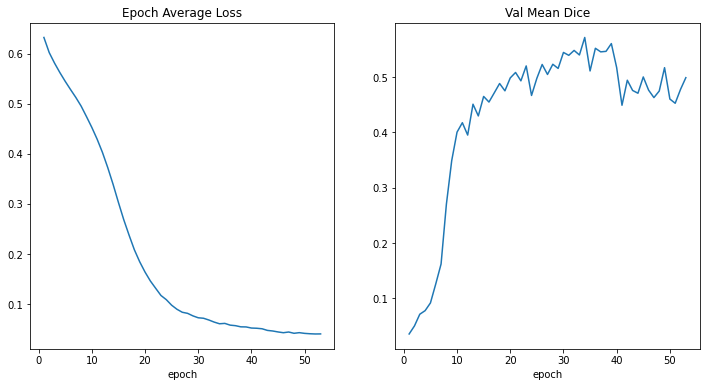

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

torch.Size([4, 2, 320, 240])


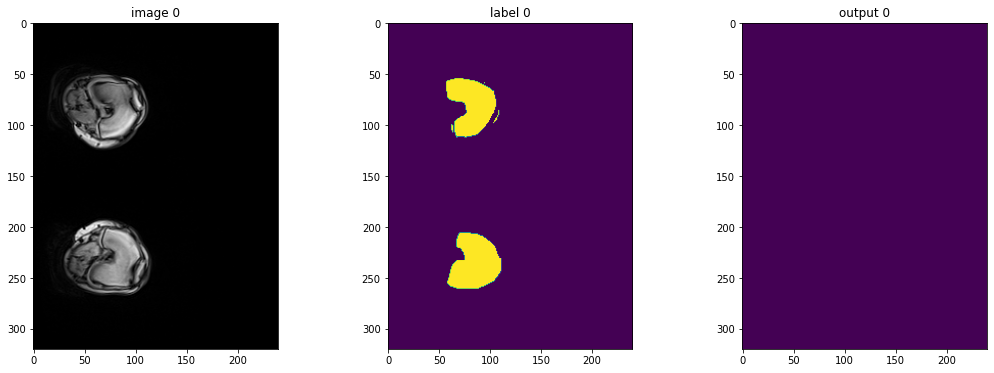

torch.Size([4, 2, 320, 240])


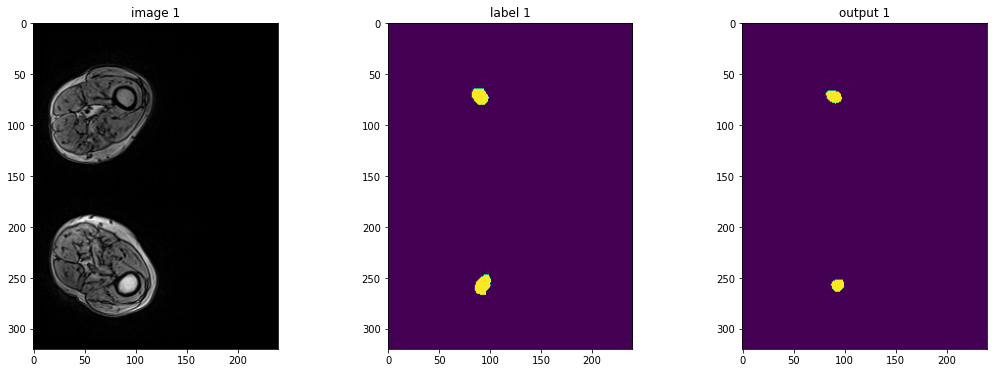

torch.Size([4, 2, 320, 240])


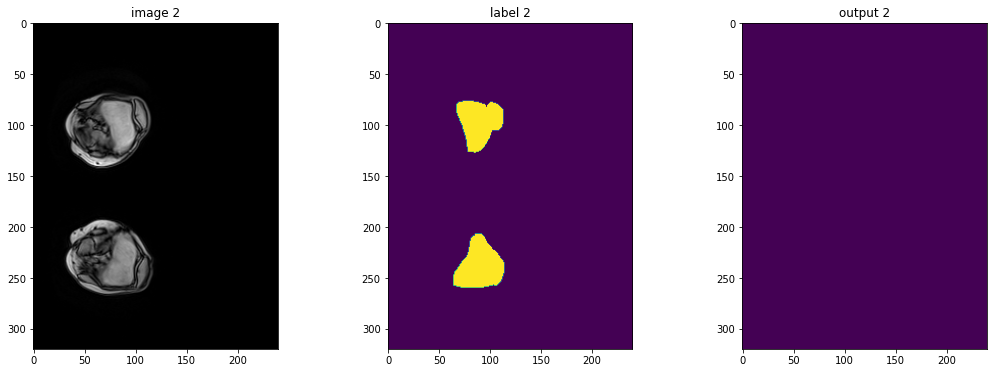

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        print(val_outputs.shape)
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[3, :, :])
        plt.show()
        if i == 2:
            break

## Evaluation on original image spacings

In [ ]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=4095,
            b_min=0.0, b_max=1.0,
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            2, 2, 2), mode=("bilinear", "nearest")),
        CropForegroundd(keys=["image", "label"], source_key="label"),
        DivisiblePadd(["image", "label"], 16),

    ]
)

val_org_ds = Dataset(
    data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    Invertd(
        keys=["pred","label"],
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys=["pred_meta_dict", "label_meta_dict"],
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
        device="cpu",
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    AsDiscreted(keys="label", to_onehot=2),
])

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.33623823523521423


## Inference on Test Set

In [ ]:
test_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

test_org_ds = Dataset(
    data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
])

In [ ]:
# # uncomment the following lines to visualize the predicted results
# from monai.transforms import LoadImage
# loader = LoadImage()

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
#         test_output = from_engine(["pred"])(test_data)

#         original_image = loader(test_output[0].meta["filename_or_obj"])

#         plt.figure("check", (18, 6))
#         plt.subplot(1, 2, 1)
#         plt.imshow(original_image[0][:, :, 20], cmap="gray")
#         plt.subplot(1, 2, 2)
#         plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
#         plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)